In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numdifftools as nd

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from registration_utilities import *
from annotation_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for AWS compute node


# 1. Compute Confidence for Global Transform

In [2]:
warp_setting = 1
classifier_setting = 37

In [3]:
stack_moving = 'atlasV3'

In [4]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_original_volume_all_known_structures(stack=stack_moving, sided=True)

File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_annotationVolume/atlasV3_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_outerContour.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_outerContour.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_outerContour.bp


Child returned 0
Child returned 1
0.60 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_sp5.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_sp5.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_sp5.bp


Child returned 1
0.60 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist.
Volume shape: (373, 430, 369)


# All Stacks

In [ ]:
for stack_fixed in all_nissl_stacks:
# for stack_fixed in ['MD595']:

    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
    DataManager.load_score_volume_all_known_structures(stack=stack_fixed, classifier_setting=classifier_setting)
    
    label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                         for label_m, name_m in label_to_structure_moving.iteritems()}
                        #     if name_m in ['7N_L', '7N_R', '12N', '5N_L', '5N_R']}
    
    aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)
    
    aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
    # aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', indices_m=[name_to_label_moving['SNR_R']])
    
    tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
        DataManager.load_alignment_parameters(stack_f=stack_fixed, stack_m=stack_moving,
                                              classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting, 
                                              warp_setting=warp_setting,
                                              downscale=32, trial_idx=trial_idx)
        
    ###############################
    ##### Compute Confidence ######
    ###############################

#     structures_for_computing_confidence = {'7N_L', '7N_R', '5N_L', '5N_R', '12N'}
#     labels_for_computing_confidence = [structure_to_label_moving[s] for s in structures_for_computing_confidence]
    labels_for_computing_confidence = label_to_structure_moving.keys()

    downscale = 32
    xy_pixel_distance = XY_PIXEL_DISTANCE_LOSSLESS * downscale

    fmax = aligner.compute_score(tx_params, indices_m=labels_for_computing_confidence)
    
    ######################
    ## Compute Hessians ##
    ######################
    
    def perturb(tx, ty, tz):
        return aligner.compute_score(tx_params + [0,0,0,tx,0,0,0,ty,0,0,0,tz],
                                 indices_m=labels_for_computing_confidence)

    hessians_all_stepsizes = {}
    stepsizes = np.linspace(1, 20, 5) # pixel size = 15um

    for stepsize in stepsizes:
        h = nd.Hessian(lambda (tx, ty, tz): perturb(tx, ty, tz), step=(stepsize, stepsize, stepsize))
        H = h((0,0,0))
        stepsize_um = stepsize * xy_pixel_distance
        hessians_all_stepsizes[stepsize_um] = (H, fmax)
        
    ##################
    ## Save hessian ##
    ##################

    fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed, 
                                       classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                       warp_setting=warp_setting, trial_idx=trial_idx,
                                       what='hessians')

    create_if_not_exists(os.path.dirname(fp))
    save_pickle(hessians_all_stepsizes, fp)
    
    #####################
    ## Compute z-score ##
    #####################
    
    zscores = {}

    # pool_radius_um_list = np.arange(25, 400, 20)
    pool_radius_um_list = np.linspace(25, 400, 5)
    for pool_radius_um in pool_radius_um_list:

        pool_radius_pixel = pool_radius_um / xy_pixel_distance

        t = time.time()

    #     grid_size = 3
    #     dxs = np.arange(-pooling_radius, pooling_radius, grid_size)
    #     dys = np.arange(-pooling_radius, pooling_radius, grid_size)
    #     dzs = np.arange(-pooling_radius, pooling_radius, grid_size)
    #     neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, dxs=dxs, dys=dys, dzs=dzs,
    #                                                                indices_m=labels_for_computing_confidence)

        neighbor_scores = aligner.compute_scores_neighborhood_random(tx_params, n=3000, 
                        stds=np.array([0,0,0,pool_radius_pixel,0,0,0,pool_radius_pixel,0,0,0,pool_radius_pixel]), 
                        indices_m=labels_for_computing_confidence)

        sys.stderr.write('Compute scores: %.2f seconds.\n' % (time.time() - t))

        mean = np.mean(neighbor_scores)
        std = np.std(neighbor_scores)
        z = (fmax - mean) / std

        zscores[pool_radius_um] = (z, fmax, mean, std)
        

    ###################
    ## Save z-scores ##
    ###################

    fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed, 
                                       classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                       warp_setting=warp_setting, trial_idx=trial_idx,
                                       what='zscores')

    create_if_not_exists(os.path.dirname(fp))
    save_pickle(zscores, fp)

File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD585/score_volumes/MD585_down32_scoreVolume_outerContour_setting_2.bp
Score volume for outerContour does not exist.
File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD585/score_volumes/MD585_down32_scoreVolume_sp5_setting_2.bp
Score volume for sp5 does not exist.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Compute scores: 128.39 seconds.
Compute scores: 112.88 seconds.
Compute scores: 117.98 seconds.
Compute scores: 112.54 seconds.
Compute scores: 114.21 seconds.
File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD589/score_volumes/MD589_down32_scoreVolume_outerContour_setting_2.bp
Score volume for outerContour does not exist.
File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD589/score_volumes/MD589_down32_scoreVolume_sp5_setting_2.bp
Score volume for sp5 does not exist.
Label weights not set, default

# ONE Stack

In [87]:
stack_fixed = 'MD635'

# Load Fixed Volumes

In [88]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, classifier_setting=classifier_setting,
                                                     sided=False, volume_type='score')

structure_subset = ['7N_L', '7N_R', '12N', '5N_L','5N_R','Pn_L', 'Pn_R', 'SNR_L', 'SNR_R', 'VLL_L', 'VLL_R', '7n_L',
          '7n_R', 'Tz_L', 'Tz_R', 'VCA_L', 'VCP_R']

# label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
#                      for label_m, name_m in label_to_structure_moving.iteritems()}
    
label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                         if name_m in structure_subset}

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes


Child returned 0

aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp



Child returned 1
1.43 seconds.
File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp
Score volume for outerContour does not exist.


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes


Child returned 0

aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp



Child returned 1
1.37 seconds.
File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp
Score volume for sp5 does not exist.
Volume shape: (445, 655, 397)


In [89]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)
aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m')

m: [ 215.   186.5  184.5] f: [ 215.   186.5  184.5]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


# Read Global Transform Estimate

In [90]:
tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
DataManager.load_alignment_parameters(stack_f=stack_fixed, stack_m=stack_moving,
                                      classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting, 
                                      warp_setting=warp_setting,
                                      type_f='score', type_m='score',
                                      downscale=32)

In [121]:
# structures_for_computing_confidence = {'7N_L'}
structures_for_computing_confidence = ['7N_L', '7N_R', '12N', '5N_L','5N_R','Pn_L', 'Pn_R', 'SNR_L', 'SNR_R', 'VLL_L', 'VLL_R', '7n_L',
          '7n_R', 'Tz_L', 'Tz_R', 'VCA_L', 'VCP_R']
labels_for_computing_confidence = [structure_to_label_moving[s] for s in structures_for_computing_confidence]
# labels_for_computing_confidence = label_to_structure_moving.keys()

fmax = aligner.compute_score(tx_params, indices_m=labels_for_computing_confidence)
print fmax

0.698684551753


In [122]:
downscale = 32
xy_pixel_distance = XY_PIXEL_DISTANCE_LOSSLESS * downscale

# Optimize

In [93]:
# gradient_filepath_map_f = {ind_f: DataManager.get_score_volume_gradient_filepath_template(\
#                             stack=stack_fixed, structure=label_to_structure_fixed[ind_f],
#                             downscale=32, setting=classifier_setting)
#                            for ind_m, ind_f in label_mapping_m2f.iteritems()}

# aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s = 2 mins

# while True:

#     try:

#         if global_transform_scheme == 1:

#             T, scores = aligner.optimize(type='affine', max_iter_num=1000, history_len=10, terminate_thresh=1e-4,
# #                                          indices_m=[name_to_label_moving['SC'], name_to_label_moving['IC'],
# #                                                    name_to_label_moving['SC_surround'], name_to_label_moving['IC_surround']],
#                                          indices_m=None,
#                                         grid_search_iteration_number=30,
#                                          grid_search_sample_number=100,
#                                          grad_computation_sample_number=1e5,
#                                          lr1=10, lr2=0.1,
#                                         std_tx=50, std_ty=50, std_tz=100, std_theta_xy=np.deg2rad(10))

#         elif global_transform_scheme == 2:

#             T, scores = aligner.optimize(type='rigid', max_iter_num=1000, history_len=10, terminate_thresh=1e-4,
#                                          indices_m=None,
#                                         grid_search_iteration_number=30,
#                                          grid_search_sample_number=100,
#                                          grad_computation_sample_number=1e5,
#                                          lr1=10, lr2=0.1,
#                                         std_tx=50, std_ty=50, std_tz=100, std_theta_xy=np.deg2rad(10))
        
#         break
        
#     except Exception as e:
#         sys.stderr.write(e.message + '\n')

# Compute Hessian

In [146]:
"""
hessians_all_stepsizes (dict): {step size in um: (Hessian matrix at the estimate, fmax)}
"""

def perturb(tx, ty, tz):
    return aligner.compute_score(tx_params + [0,0,0,tx,0,0,0,ty,0,0,0,tz],
                                 indices_m=labels_for_computing_confidence)

hessians_all_stepsizes = {}
stepsizes = np.linspace(1, 20, 5) # pixel size = 15um

for stepsize in stepsizes:
    h = nd.Hessian(lambda (tx, ty, tz): perturb(tx, ty, tz), step=(stepsize, stepsize, stepsize))
    H = h((0,0,0))
    stepsize_um = stepsize * xy_pixel_distance
    hessians_all_stepsizes[stepsize_um] = (H, fmax)

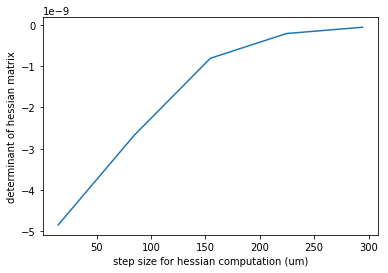

In [154]:
ss = [stepsize_um for stepsize_um, (H, _) in sorted(hessians_all_stepsizes.iteritems())]
hs = [np.linalg.det(H) for stepsize_um, (H, _) in sorted(hessians_all_stepsizes.iteritems())]
plt.plot(ss, hs);
plt.xlabel('step size for hessian computation (um)');
plt.ylabel('determinant of hessian matrix');

In [174]:
# Save hessian

fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed, 
                                         type_m='score', type_f='score',
                                         classifier_setting_m=classifier_setting, 
                                         classifier_setting_f=classifier_setting,
                                         warp_setting=warp_setting,
                                         what='hessians')

create_parent_dir_if_not_exists(fp)
save_pickle(hessians_all_stepsizes, fp)
upload_to_s3(fp)

aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_parameters_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_parameters_hessians.pkl


Child returned 0
0.75 seconds.


# Compute z-score

In [155]:
"""
zscores (dict): {pooling radius in um: (z, fmax, mean, std)}
"""

zscores = {}

# pool_radius_um_list = np.arange(25, 400, 20)
pool_radius_um_list = np.linspace(25, 400, 5)
for pool_radius_um in pool_radius_um_list:
    
    pool_radius_pixel = pool_radius_um / xy_pixel_distance

    t = time.time()
    
#     grid_size = 3
#     dxs = np.arange(-pooling_radius, pooling_radius, grid_size)
#     dys = np.arange(-pooling_radius, pooling_radius, grid_size)
#     dzs = np.arange(-pooling_radius, pooling_radius, grid_size)
#     neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, dxs=dxs, dys=dys, dzs=dzs,
#                                                                indices_m=labels_for_computing_confidence)
    
    neighbor_scores = aligner.compute_scores_neighborhood_random(tx_params, n=3000, 
                    stds=np.array([0,0,0,pool_radius_pixel,0,0,0,pool_radius_pixel,0,0,0,pool_radius_pixel]), 
                    indices_m=labels_for_computing_confidence)
    
    sys.stderr.write('Compute scores: %.2f seconds.\n' % (time.time() - t))
    
    mean = np.mean(neighbor_scores)
    std = np.std(neighbor_scores)
    z = (fmax - mean) / std
    
    zscores[pool_radius_um] = (z, fmax, mean, std)

Compute scores: 28.24 seconds.
Compute scores: 28.17 seconds.
Compute scores: 28.61 seconds.
Compute scores: 28.47 seconds.
Compute scores: 28.23 seconds.


In [175]:
# Save z-scores

fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed, 
                                    type_m='score', type_f='score',
                                   classifier_setting_m=classifier_setting, 
                                         classifier_setting_f=classifier_setting,
                                   warp_setting=warp_setting,
                                   what='zscores')

create_parent_dir_if_not_exists(fp)
save_pickle(zscores, fp)
upload_to_s3(fp)

aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_parameters_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_parameters_zscores.pkl


Child returned 0
0.75 seconds.


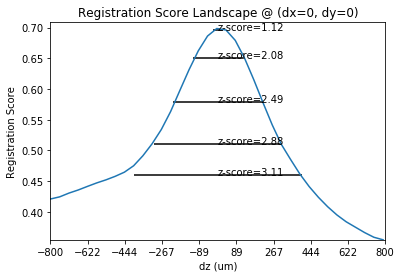

In [156]:
# Visualize a z-slice of the registration score function.

max_pooling_radius_um = 800
max_pooling_radius_pixel = max_pooling_radius_um / xy_pixel_distance

grid_size = 3
dzs = np.arange(-max_pooling_radius_pixel, max_pooling_radius_pixel, grid_size)
neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, dxs=[0], dys=[0], dzs=dzs,
                                                           indices_m=labels_for_computing_confidence)
plt.figure();
plt.plot(dzs * xy_pixel_distance, neighbor_scores)
plt.ylim([np.min(neighbor_scores), np.max(neighbor_scores) + .01]);
plt.xlim([-max_pooling_radius_um, max_pooling_radius_um]);
plt.title('Registration Score Landscape @ (dx=0, dy=0)')
plt.ylabel('Registration Score');
plt.xlabel('dz (um)');
plt.xticks(np.linspace(-max_pooling_radius_um, max_pooling_radius_um, 10));

for poolradius_um, (z, fmax, mean, std) in zscores.iteritems():
    plt.hlines(mean, -poolradius_um, poolradius_um);
    plt.text(x=0, y=mean, s='z-score=%.2f'%z, fontsize=10);

plt.show();

- The width of each black bar corresponds to the size of the pooling region.
- The height of each black bar is the mean score in that pooling region.
- The z-score is higher if the pooling region is larger.

# Compute Peak Radius
- Use the pre-computed hessian matrix to approximate a neighborhood around score maxima by a quadratic function. The neighborhood size is controlled by step size $\delta$.
- The hessian matrix also gives the directions of min and max change.
- Peak radius is the distance from the maxima along either the min or max direction that the quadratic approximation drops to the mean of neighborhood N2. This neighborhood is specified by a pooling radius $r$.

In [123]:
stack_moving = 'atlasV2'
stack_fixed = 'MD635'

In [130]:
classifier_setting = 37
warp_setting = 1

In [131]:
downscale = 32
xy_pixel_distance = XY_PIXEL_DISTANCE_LOSSLESS * downscale

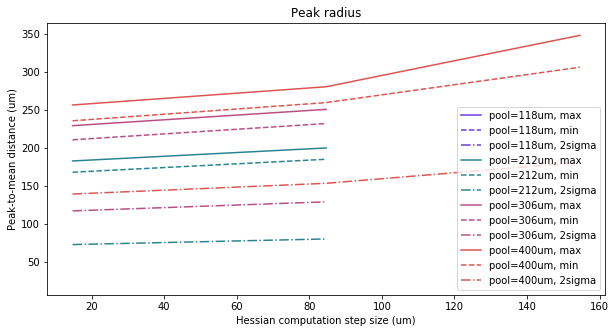

In [173]:
from collections import defaultdict
peak_radius_all_stacks = defaultdict(list)

# for stack_fixed in all_nissl_stacks:
for stack_fixed in ['MD635']:
    
    # Load previously computed confidence measures

    zscores = DataManager.load_confidence(stack_m=stack_moving, stack_f=stack_fixed, 
                                       classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                       warp_setting=warp_setting,
                                       what='zscores')

    hessians_all_stepsizes = DataManager.load_confidence(stack_m=stack_moving, stack_f=stack_fixed, 
                                       classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                       warp_setting=warp_setting,
                                       what='hessians')
    
    peak_radius = defaultdict(dict)
    for poolradius_um, (zscore, fmax, mu, std) in zscores.iteritems():
        for stepsize_um, (H, fmax) in hessians_all_stepsizes.iteritems():
            if poolradius_um > stepsize_um * 2:  # compute only if pooling radius is at least twice the step size
                U, S, UT = np.linalg.svd(H)

                # using the smallest eigenvalues of Hessians (flattest direction), score drops to mean
                peak_radius_pixel_max = np.sqrt(2*(fmax-mu)/S[-1])

                # using the largest eigenvalues of Hessians (steepest direction), score drops to mean
                peak_radius_pixel_min = np.sqrt(2*(fmax-mu)/S[0])

                # using the largest eigenvalues of Hessians, scores drops to the value with 2-sigma significance
                peak_radius_pixel_2sigma = np.sqrt(2*(fmax-(mu+2*std))/S[0])

                peak_radius[poolradius_um][stepsize_um] = (peak_radius_pixel_max * xy_pixel_distance,
                                                          peak_radius_pixel_min * xy_pixel_distance,
                                                          peak_radius_pixel_2sigma * xy_pixel_distance)
    peak_radius.default_factory = None

    # Plot
    plt.figure(figsize=(10,5));
    for poolradius_um, v in sorted(peak_radius.items()):
        xs, ys_max_min_2sigma = zip(*sorted(v.items()))
        ys_max, ys_min, ys_2sigma = zip(*ys_max_min_2sigma)
        c = np.array(random_colors(1)[0])/255.
        plt.plot(xs, ys_max, linestyle='-', color=c, label='pool=%dum, max' % poolradius_um);
        plt.plot(xs, ys_min, linestyle='--', color=c, label='pool=%dum, min' % poolradius_um);
        plt.plot(xs, ys_2sigma, linestyle='-.', color=c, label='pool=%dum, 2sigma' % poolradius_um);
    plt.legend(loc='lower right');
    plt.title('Peak radius');
    plt.xlabel('Hessian computation step size (um)');
    plt.ylabel('Peak-to-mean distance (um)');
    plt.show();

# Plot z-scores and hessians for all stacks

In [176]:
stack_moving = 'atlasV3'

zscores_all_stacks = {}
hessians_all_stacks_all_stepsizes = {}

# for stack_fixed in all_nissl_stacks:
for stack_fixed in ['MD635']:

    zscores = DataManager.load_confidence(stack_m=stack_moving, stack_f=stack_fixed, 
                                       classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                       warp_setting=warp_setting,
                                       what='zscores')

    hessians_all_stepsizes = DataManager.load_confidence(stack_m=stack_moving, stack_f=stack_fixed, 
                                       classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                       warp_setting=warp_setting,
                                       what='hessians')
    
    zscores_all_stacks[stack_fixed] = zscores
    hessians_all_stacks_all_stepsizes[stack_fixed] = hessians_all_stepsizes

## plot z-scores for all stacks

In [177]:
pool_radius_list = sorted(zscores_all_stacks.values()[0].keys())

In [178]:
# choose to use which pooling radius for z-score

pool_radius = pool_radius_list[1]
print pool_radius

118.75


In [179]:
zscore_toplot_all_stacks = {st: zs[pool_radius][0] for st, zs in zscores_all_stacks.iteritems()}

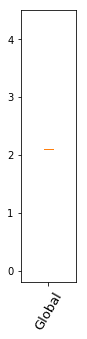

In [180]:
plt.figure(figsize=(1, 5));
D = [zscore_toplot_all_stacks.values()]
plt.boxplot(D);
plt.ylim([-.2,4.5]);
plt.xticks(range(1, 2), ['Global'], rotation='60', fontsize=13);

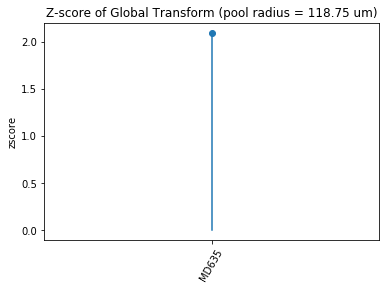

In [181]:
plt.stem(zscore_toplot_all_stacks.values());
plt.xticks(range(len(zscore_toplot_all_stacks)), zscore_toplot_all_stacks.keys(), rotation='60');
plt.title('Z-score of Global Transform (pool radius = %.2f um)' % pool_radius);
plt.ylabel('zscore');

# 2. Compute Confidence for Local Transforms

In [183]:
warp_setting = 8
classifier_setting = 37

In [184]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
else:
    upstream_warp_setting = int(upstream_warp_setting)
    
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
print std_tx, std_ty, std_tz, std_theta_xy

reg_weight = warp_properties['regularization_weight']
reg_weights = np.ones((3,))*reg_weight

surround_weight = warp_properties['surround_weight']
# surround_weight = -.5
include_surround = surround_weight != 0

upstream_warp_id                        1
transform_type                      rigid
terminate_thresh                    1e-06
grad_computation_sample_number     100000
grid_search_sample_number           10000
std_tx_um                             200
std_ty_um                             200
std_tz_um                             200
std_theta_xy_degree                    30
surround_weight                   inverse
regularization_weight                   0
Name: 8, dtype: object
13.5869565217 13.5869565217 13.5869565217 0.523598775598


In [185]:
stack_moving = 'atlasV3'

# Compute z-scores and hessians for all structures for all stacks

In [212]:
downscale = 32
xy_pixel_distance = XY_PIXEL_DISTANCE_LOSSLESS * downscale

In [213]:
# for stack_fixed in all_nissl_stacks:
for stack_fixed in ['MD635']:

    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
    DataManager.load_original_volume_all_known_structures(stack=stack_fixed, 
                                                          classifier_setting=classifier_setting,
                                                         sided=False, volume_type='score')

    for structure in all_known_structures_sided:
#     for structure in ['7N_L']:

        try:
            
            ##############################
            # Initialize aligner object. #
            ##############################
            
            if include_surround:
                volume_moving = DataManager.load_transformed_volume_all_known_structures(stack_m=stack_moving, stack_f=stack_fixed,
                                                                             classifier_setting_m=classifier_setting,
                                                                             classifier_setting_f=classifier_setting,
                                                                             warp_setting=upstream_warp_setting, 
                                                                             structures=[structure, 
                                                                                         convert_to_surround_name(structure, margin='200')])
            else:
                volume_moving = DataManager.load_transformed_volume_all_known_structures(stack_m=stack_moving, stack_f=stack_fixed,
                                                                             classifier_setting_m=classifier_setting,
                                                                             classifier_setting_f=classifier_setting,
                                                                             warp_setting=upstream_warp_setting, 
                                                                             structures=[structure])

            structure_to_label_moving = {s: l+1 for l, s in enumerate(sorted(volume_moving.keys()))}
            label_to_structure_moving = {l+1: s for l, s in enumerate(sorted(volume_moving.keys()))}
            volume_moving = {structure_to_label_moving[s]: v for s, v in volume_moving.items()}

            volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}

            label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                                 for label_m, name_m in label_to_structure_moving.iteritems()}

            if surround_weight == 'inverse':
                label_weights_m = {label_m: -volume_moving_structure_sizes[structure_to_label_moving[convert_to_nonsurround_name(name_m)]]
                                   /float(volume_moving_structure_sizes[label_m])
                                   if is_surround_label(name_m) else 1. \
                                   for label_m, name_m in label_to_structure_moving.iteritems()}
            elif isinstace(surround_weight, int) or isinstace(surround_weight, float):
                label_weights_m = {label_m: surround_weight if is_surround_label(name_m) else 1. \
                                   for label_m, name_m in label_to_structure_moving.iteritems()}
            else:
                sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

            aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

            aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', 
                                 indices_m=[structure_to_label_moving[structure]])                            

            aligner.set_regularization_weights(reg_weights)
            aligner.set_label_weights(label_weights_m)

            ########################################
            # Read previous computed best estimate #
            ########################################

            tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
            DataManager.load_alignment_parameters(stack_m=stack_moving, stack_f=stack_fixed,
                                                  classifier_setting_m=classifier_setting,
                                                  classifier_setting_f=classifier_setting,
                                                  warp_setting=warp_setting,
                                                  param_suffix=structure)


    #         structures_for_computing_confidence = {'7N_L', '7N_R', '5N_L', '5N_R', '12N'}
    #         labels_for_computing_confidence = [structure_to_label_moving[s] for s in structures_for_computing_confidence]
    #         labels_for_computing_confidence = label_to_structure_moving.keys()

            labels_for_computing_confidence = [structure_to_label_moving[structure]]

            fmax = aligner.compute_score(tx_params, indices_m=labels_for_computing_confidence)

            ####################
            # Compute Hessians #
            ####################

            def perturb(tx, ty, tz):
                return aligner.compute_score(tx_params + [0,0,0,tx,0,0,0,ty,0,0,0,tz],
                                             indices_m=labels_for_computing_confidence)

            hessians_all_stepsizes = {}
            stepsizes = np.linspace(1, 20, 5) # pixel size = 15um

            for stepsize in stepsizes:
                h = nd.Hessian(lambda (tx, ty, tz): perturb(tx, ty, tz), step=(stepsize, stepsize, stepsize))
                H = h((0,0,0))
                stepsize_um = stepsize * xy_pixel_distance
                hessians_all_stepsizes[stepsize_um] = (H, fmax)

            #################
            # Save hessians #
            #################

            fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                   classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                                   warp_setting=warp_setting,
                                                     param_suffix=structure,
                                                     what='hessians')

            create_parent_dir_if_not_exists(fp)
            save_pickle(hessians_all_stepsizes, fp)
            upload_to_s3(fp)

            ###################
            # Compute z-score #
            ###################

            zscores = {}

            # pool_radius_um_list = np.arange(25, 400, 20)
            pool_radius_um_list = np.linspace(25, 400, 5)
            for pool_radius_um in pool_radius_um_list:

                pool_radius_pixel = pool_radius_um / xy_pixel_distance

                t = time.time()

            #     grid_size = 3
            #     dxs = np.arange(-pooling_radius, pooling_radius, grid_size)
            #     dys = np.arange(-pooling_radius, pooling_radius, grid_size)
            #     dzs = np.arange(-pooling_radius, pooling_radius, grid_size)
            #     neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, dxs=dxs, dys=dys, dzs=dzs,
            #                                                                indices_m=labels_for_computing_confidence)

                neighbor_scores = aligner.compute_scores_neighborhood_random(tx_params, n=3000, 
                                stds=np.array([0,0,0,pool_radius_pixel,0,0,0,pool_radius_pixel,0,0,0,pool_radius_pixel]), 
                                indices_m=labels_for_computing_confidence)

                sys.stderr.write('Compute scores: %.2f seconds.\n' % (time.time() - t))

                mean = np.mean(neighbor_scores)
                std = np.std(neighbor_scores)
                z = (fmax - mean) / std

                zscores[pool_radius_um] = (z, fmax, mean, std)

            #################
            # Save z-scores #
            #################

            fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                     classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                                     warp_setting=warp_setting,
                                                     param_suffix=structure,
                                                     what='zscores')
            create_parent_dir_if_not_exists(fp)
            save_pickle(zscores, fp)
            upload_to_s3(fp)

        except Exception as e:
            sys.stderr.write('%s\n' % e)
            sys.stderr.write('Error transforming volume %s.\n' % structure)

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp


Child returned 1
0.91 seconds.
File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp
Score volume for outerContour does not exist.


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp


Child returned 1
0.97 seconds.
File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp
Score volume for sp5 does not exist.
Volume shape: (445, 655, 397)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 241.20334087  268.36674202  102.34059282] f: [ 241.20334087  268.36674202  102.34059282]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_L_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 1.77 seconds.
Compute scores: 1.79 seconds.
Compute scores: 1.79 seconds.
Compute scores: 1.78 seconds.
Compute scores: 1.80 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_L_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 241.52676353  257.43318527  288.16017968] f: [ 241.52676353  257.43318527  288.16017968]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_R_hessians.pkl


Child returned 0
0.56 seconds.
Compute scores: 1.79 seconds.
Compute scores: 1.77 seconds.
Compute scores: 1.78 seconds.
Compute scores: 1.79 seconds.
Compute scores: 1.79 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_R_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 282.12774339  256.52504221  170.10185706] f: [ 282.12774339  256.52504221  170.10185706]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_L_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 1.41 seconds.
Compute scores: 1.41 seconds.
Compute scores: 1.30 seconds.
Compute scores: 1.30 seconds.
Compute scores: 1.42 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_L_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 282.2424581   253.65307263  218.99273743] f: [ 282.2424581   253.65307263  218.99273743]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_R_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 1.27 seconds.
Compute scores: 1.27 seconds.
Compute scores: 1.29 seconds.
Compute scores: 1.41 seconds.
Compute scores: 1.41 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_R_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 309.54096748  320.93823449  120.77705657] f: [ 309.54096748  320.93823449  120.77705657]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_L_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 2.38 seconds.
Compute scores: 2.39 seconds.
Compute scores: 2.48 seconds.
Compute scores: 2.39 seconds.
Compute scores: 2.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_L_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 309.8139484   311.83507324  275.56293725] f: [ 309.8139484   311.83507324  275.56293725]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_R_hessians.pkl


Child returned 0
0.56 seconds.
Compute scores: 2.39 seconds.
Compute scores: 2.49 seconds.
Compute scores: 2.48 seconds.
Compute scores: 2.39 seconds.
Compute scores: 2.50 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_R_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 272.83870756  281.0801219   122.96559182] f: [ 272.83870756  281.0801219   122.96559182]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_L_hessians.pkl


Child returned 0
0.52 seconds.
Compute scores: 1.58 seconds.
Compute scores: 1.58 seconds.
Compute scores: 1.58 seconds.
Compute scores: 1.59 seconds.
Compute scores: 1.61 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_L_zscores.pkl


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 273.070885    272.52076363  269.00328019] f: [ 273.070885    272.52076363  269.00328019]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_R_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 1.58 seconds.
Compute scores: 1.57 seconds.
Compute scores: 1.58 seconds.
Compute scores: 1.58 seconds.
Compute scores: 1.59 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_R_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 358.02871452  296.42971619  112.17295492] f: [ 358.02871452  296.42971619  112.17295492]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_L_hessians.pkl


Child returned 0
0.86 seconds.
Compute scores: 1.43 seconds.
Compute scores: 1.27 seconds.
Compute scores: 1.28 seconds.
Compute scores: 1.30 seconds.
Compute scores: 1.42 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_L_zscores.pkl


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 358.16364247  286.58266129  280.95564516] f: [ 358.16364247  286.58266129  280.95564516]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_R_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 1.27 seconds.
Compute scores: 1.27 seconds.
Compute scores: 1.29 seconds.
Compute scores: 1.31 seconds.
Compute scores: 1.27 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_R_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 251.55632285  220.77083666  137.11270557] f: [ 251.55632285  220.77083666  137.11270557]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_L_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 1.99 seconds.
Compute scores: 1.98 seconds.
Compute scores: 1.98 seconds.
Compute scores: 1.98 seconds.
Compute scores: 1.98 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_L_zscores.pkl


Child returned 0
0.56 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 251.75071879  214.24305167  247.97342465] f: [ 251.75071879  214.24305167  247.97342465]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_R_hessians.pkl


Child returned 0
0.57 seconds.
Compute scores: 1.98 seconds.
Compute scores: 1.99 seconds.
Compute scores: 1.98 seconds.
Compute scores: 1.98 seconds.
Compute scores: 1.99 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_R_zscores.pkl


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 414.22821182  303.39115391  134.05077136] f: [ 414.22821182  303.39115391  134.05077136]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_L_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 3.89 seconds.
Compute scores: 3.99 seconds.
Compute scores: 3.91 seconds.
Compute scores: 4.08 seconds.
Compute scores: 3.89 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_L_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 414.46789368  296.0024411   259.6274256 ] f: [ 414.46789368  296.0024411   259.6274256 ]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_R_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 4.08 seconds.
Compute scores: 3.88 seconds.
Compute scores: 4.10 seconds.
Compute scores: 3.90 seconds.
Compute scores: 3.90 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_R_zscores.pkl


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 180.47570258  345.55096186  161.09467213] f: [ 180.47570258  345.55096186  161.09467213]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_L_hessians.pkl


Child returned 0
0.52 seconds.
Compute scores: 3.49 seconds.
Compute scores: 3.69 seconds.
Compute scores: 3.62 seconds.
Compute scores: 3.60 seconds.
Compute scores: 3.68 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_L_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 180.61289406  340.94445791  239.2490449 ] f: [ 180.61289406  340.94445791  239.2490449 ]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_R_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 3.50 seconds.
Compute scores: 3.48 seconds.
Compute scores: 3.59 seconds.
Compute scores: 3.49 seconds.
Compute scores: 3.47 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_R_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 246.61669401  343.20431706  164.33162428] f: [ 246.61669401  343.20431706  164.33162428]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_L_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 1.48 seconds.
Compute scores: 1.41 seconds.
Compute scores: 1.49 seconds.
Compute scores: 1.47 seconds.
Compute scores: 1.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_L_zscores.pkl


Child returned 0
0.61 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 246.75236488  339.07199468  234.21802935] f: [ 246.75236488  339.07199468  234.21802935]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_R_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 1.48 seconds.
Compute scores: 1.48 seconds.
Compute scores: 1.49 seconds.
Compute scores: 1.48 seconds.
Compute scores: 1.48 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_R_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 196.58185633  288.72258627   92.9572497 ] f: [ 196.58185633  288.72258627   92.9572497 ]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_L_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 2.59 seconds.
Compute scores: 2.72 seconds.
Compute scores: 2.60 seconds.
Compute scores: 2.50 seconds.
Compute scores: 2.50 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_L_zscores.pkl


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 196.91696854  276.48755277  300.1562849 ] f: [ 196.91696854  276.48755277  300.1562849 ]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_R_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 2.59 seconds.
Compute scores: 2.58 seconds.
Compute scores: 2.59 seconds.
Compute scores: 2.59 seconds.
Compute scores: 2.72 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_R_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 148.4286001   252.63863522  160.70496739] f: [ 148.4286001   252.63863522  160.70496739]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_L_hessians.pkl


Child returned 0
0.57 seconds.
Compute scores: 1.77 seconds.
Compute scores: 1.79 seconds.
Compute scores: 1.78 seconds.
Compute scores: 1.78 seconds.
Compute scores: 1.78 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_L_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 148.54874931  248.61123365  228.9518021 ] f: [ 148.54874931  248.61123365  228.9518021 ]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_R_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 1.78 seconds.
Compute scores: 1.79 seconds.
Compute scores: 1.78 seconds.
Compute scores: 1.78 seconds.
Compute scores: 1.78 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_R_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 122.53938149  294.01812339  113.69875138] f: [ 122.53938149  294.01812339  113.69875138]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_L_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 1.48 seconds.
Compute scores: 1.40 seconds.
Compute scores: 1.49 seconds.
Compute scores: 1.49 seconds.
Compute scores: 1.48 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_L_zscores.pkl


Child returned 0
0.56 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 122.80876915  284.23639725  279.659271  ] f: [ 122.80876915  284.23639725  279.659271  ]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_R_hessians.pkl


Child returned 0
0.56 seconds.
Compute scores: 1.41 seconds.
Compute scores: 1.47 seconds.
Compute scores: 1.39 seconds.
Compute scores: 1.49 seconds.
Compute scores: 1.48 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_R_zscores.pkl


Child returned 0
0.55 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 141.7883487   284.9134243   101.25432109] f: [ 141.7883487   284.9134243   101.25432109]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_L_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 5.41 seconds.
Compute scores: 5.40 seconds.
Compute scores: 5.40 seconds.
Compute scores: 5.30 seconds.
Compute scores: 5.51 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_L_zscores.pkl


Child returned 0
0.61 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 142.10117456  273.66653934  291.83907351] f: [ 142.10117456  273.66653934  291.83907351]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_R_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 5.31 seconds.
Compute scores: 5.43 seconds.
Compute scores: 5.29 seconds.
Compute scores: 5.39 seconds.
Compute scores: 5.40 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_R_zscores.pkl


Child returned 0
0.56 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 161.9494996   214.80536063  182.51777292] f: [ 161.9494996   214.80536063  182.51777292]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_L_hessians.pkl


Child returned 0
0.50 seconds.
Compute scores: 1.28 seconds.
Compute scores: 1.45 seconds.
Compute scores: 1.28 seconds.
Compute scores: 1.29 seconds.
Compute scores: 1.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_L_zscores.pkl


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 162.01527331  213.57510335  202.81511254] f: [ 162.01527331  213.57510335  202.81511254]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_R_hessians.pkl


Child returned 0
0.56 seconds.
Compute scores: 1.38 seconds.
Compute scores: 1.40 seconds.
Compute scores: 1.38 seconds.
Compute scores: 1.37 seconds.
Compute scores: 1.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_R_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 186.18309859  210.36205468  175.12096106] f: [ 186.18309859  210.36205468  175.12096106]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_L_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 1.41 seconds.
Compute scores: 1.37 seconds.
Compute scores: 1.30 seconds.
Compute scores: 1.30 seconds.
Compute scores: 1.29 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_L_zscores.pkl


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 186.25894378  208.37052811  209.6746167 ] f: [ 186.25894378  208.37052811  209.6746167 ]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_R_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 1.40 seconds.
Compute scores: 1.28 seconds.
Compute scores: 1.32 seconds.
Compute scores: 1.31 seconds.
Compute scores: 1.28 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_R_zscores.pkl


Child returned 0
0.56 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 387.98083621  251.63684451   62.90716517] f: [ 387.98083621  251.63684451   62.90716517]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_L_hessians.pkl


Child returned 0
1.28 seconds.
Compute scores: 3.70 seconds.
Compute scores: 3.70 seconds.
Compute scores: 3.59 seconds.
Compute scores: 3.61 seconds.
Compute scores: 3.68 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_L_zscores.pkl


Child returned 0
0.56 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 388.43245452  236.22516794  324.40723427] f: [ 388.43245452  236.22516794  324.40723427]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_R_hessians.pkl


Child returned 0
0.56 seconds.
Compute scores: 3.90 seconds.
Compute scores: 3.60 seconds.
Compute scores: 3.80 seconds.
Compute scores: 3.62 seconds.
Compute scores: 3.80 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_R_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 335.37698638  270.36057932   68.7824315 ] f: [ 335.37698638  270.36057932   68.7824315 ]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_L_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 3.38 seconds.
Compute scores: 3.50 seconds.
Compute scores: 3.50 seconds.
Compute scores: 3.49 seconds.
Compute scores: 3.48 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_L_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 335.8219985   255.5427263   320.10829707] f: [ 335.8219985   255.5427263   320.10829707]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_R_hessians.pkl


Child returned 0
0.56 seconds.
Compute scores: 3.40 seconds.
Compute scores: 3.49 seconds.
Compute scores: 3.38 seconds.
Compute scores: 3.51 seconds.
Compute scores: 3.49 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_R_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 438.45257496  254.17274618   98.65791045] f: [ 438.45257496  254.17274618   98.65791045]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_L_hessians.pkl


Child returned 0
0.56 seconds.
Compute scores: 7.40 seconds.
Compute scores: 7.34 seconds.
Compute scores: 7.62 seconds.
Compute scores: 7.50 seconds.
Compute scores: 7.20 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_L_zscores.pkl


Child returned 0
0.56 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 438.78062541  242.95270953  288.8644516 ] f: [ 438.78062541  242.95270953  288.8644516 ]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_R_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 7.22 seconds.
Compute scores: 7.12 seconds.
Compute scores: 7.11 seconds.
Compute scores: 7.30 seconds.
Compute scores: 7.12 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_R_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 178.71884498  204.64189002   66.29068804] f: [ 178.71884498  204.64189002   66.29068804]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_L_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 1.43 seconds.
Compute scores: 1.38 seconds.
Compute scores: 1.41 seconds.
Compute scores: 1.29 seconds.
Compute scores: 1.28 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_L_zscores.pkl


Child returned 0
0.56 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 179.20948012  189.85460106  316.88990826] f: [ 179.20948012  189.85460106  316.88990826]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_R_hessians.pkl


Child returned 0
0.56 seconds.
Compute scores: 1.30 seconds.
Compute scores: 1.28 seconds.
Compute scores: 1.31 seconds.
Compute scores: 1.40 seconds.
Compute scores: 1.28 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_R_zscores.pkl


Child returned 0
0.56 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 403.7607468   239.0021897   174.38676962] f: [ 403.7607468   239.0021897   174.38676962]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_L_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 1.37 seconds.
Compute scores: 1.41 seconds.
Compute scores: 1.40 seconds.
Compute scores: 1.37 seconds.
Compute scores: 1.39 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_L_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 403.90735568  236.78340317  212.31017225] f: [ 403.90735568  236.78340317  212.31017225]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_R_hessians.pkl


Child returned 0
0.50 seconds.
Compute scores: 1.28 seconds.
Compute scores: 1.30 seconds.
Compute scores: 1.45 seconds.
Compute scores: 1.38 seconds.
Compute scores: 1.41 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_R_zscores.pkl


Child returned 0
0.56 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 267.62269116  257.30523104   28.78225386] f: [ 267.62269116  257.30523104   28.78225386]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_L_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 2.68 seconds.
Compute scores: 2.59 seconds.
Compute scores: 2.60 seconds.
Compute scores: 2.50 seconds.
Compute scores: 2.40 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_L_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 268.18257805  237.86310781  358.74177502] f: [ 268.18257805  237.86310781  358.74177502]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_R_hessians.pkl


Child returned 0
0.61 seconds.
Compute scores: 2.58 seconds.
Compute scores: 2.59 seconds.
Compute scores: 2.51 seconds.
Compute scores: 2.59 seconds.
Compute scores: 2.41 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_R_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 307.23302108  257.25951405   37.29435012] f: [ 307.23302108  257.25951405   37.29435012]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_L_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 1.79 seconds.
Compute scores: 1.79 seconds.
Compute scores: 1.79 seconds.
Compute scores: 1.91 seconds.
Compute scores: 1.89 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_L_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 307.77349186  238.74653939  351.01691853] f: [ 307.77349186  238.74653939  351.01691853]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_R_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 1.78 seconds.
Compute scores: 1.79 seconds.
Compute scores: 1.77 seconds.
Compute scores: 1.79 seconds.
Compute scores: 1.89 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_R_zscores.pkl


Child returned 0
0.82 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 309.81469744  216.72138244   44.39357809] f: [ 309.81469744  216.72138244   44.39357809]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_L_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 2.68 seconds.
Compute scores: 2.58 seconds.
Compute scores: 2.58 seconds.
Compute scores: 2.78 seconds.
Compute scores: 2.68 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_L_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 310.32059014  199.36683658  338.20180918] f: [ 310.32059014  199.36683658  338.20180918]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_R_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 2.68 seconds.
Compute scores: 2.68 seconds.
Compute scores: 2.68 seconds.
Compute scores: 2.68 seconds.
Compute scores: 2.68 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_R_zscores.pkl


Child returned 0
0.56 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 397.18472828  223.96692545  192.62671488] f: [ 397.18472828  223.96692545  192.62671488]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_AP_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_AP_hessians.pkl


Child returned 0
0.50 seconds.
Compute scores: 1.29 seconds.
Compute scores: 1.42 seconds.
Compute scores: 1.39 seconds.
Compute scores: 1.39 seconds.
Compute scores: 1.40 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_AP_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_AP_zscores.pkl


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 401.81007262  249.98365713  193.9745585 ] f: [ 401.81007262  249.98365713  193.9745585 ]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_12N_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_12N_hessians.pkl


Child returned 0
0.51 seconds.
Compute scores: 2.08 seconds.
Compute scores: 2.00 seconds.
Compute scores: 2.08 seconds.
Compute scores: 2.18 seconds.
Compute scores: 2.18 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_12N_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_12N_zscores.pkl


Child returned 0
0.56 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 205.22237628  317.53367045  198.62264271] f: [ 205.22237628  317.53367045  198.62264271]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RtTg_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RtTg_hessians.pkl


Child returned 0
0.61 seconds.
Compute scores: 6.31 seconds.
Compute scores: 6.30 seconds.
Compute scores: 6.11 seconds.
Compute scores: 6.41 seconds.
Compute scores: 6.31 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RtTg_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RtTg_zscores.pkl


Child returned 0
0.51 seconds.
Child returned 0

rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes



Child returned 1
0.63 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5.bp
[Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5.bp'
Score volume for sp5 does not exist.
Child returned

aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5.bp
rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes


 0
Child returned 1
0.63 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5_surround_200.bp
[Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5_surround_200.bp'
Score volume for sp5_surround_200 does not exist.
list index out of range
Error transforming volume sp5.
Child returned

aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5_surround_200.bp
rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_

 0
Child returned 1
0.63 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour.bp
[Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour.bp'
Score volume for outerContour does not exist.
Child returned

rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes


 0
Child returned 1
0.65 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour_surround_200.bp
[Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour_surround_200.bp'
Score volume for outerContour_surround_200 does not exist.
list index out of range
Error transforming volume outerContour.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour_surround_200.bp
m: [ 141.62347339  135.84237371  188.40012208] f: [ 141.62347339  135.84237371  188.40012208]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SC_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_param

Child returned 0
0.51 seconds.
Compute scores: 51.98 seconds.
Compute scores: 51.69 seconds.
Compute scores: 52.29 seconds.
Compute scores: 51.70 seconds.
Compute scores: 50.71 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SC_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SC_zscores.pkl


Child returned 0
0.56 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 211.61283808  105.189224    185.77682554] f: [ 211.61283808  105.189224    185.77682554]
aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_IC_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_IC_hessians.pkl


Child returned 0
0.56 seconds.
Compute scores: 33.34 seconds.
Compute scores: 33.16 seconds.
Compute scores: 32.92 seconds.
Compute scores: 33.33 seconds.
Compute scores: 33.95 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_IC_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_IC_zscores.pkl


Child returned 0
0.56 seconds.


# Plot structure-wise registration score landscape 

In [229]:
# Load all pre-computed z-scores.

zscores_all_stacks_all_structures = defaultdict(dict)

# for stack_fixed in all_nissl_stacks:
for stack_fixed in ['MD635']:

    for structure in all_known_structures_sided:
        try:
            zscores = DataManager.load_confidence(stack_m=stack_moving, stack_f=stack_fixed, 
                                               classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                               warp_setting=warp_setting,
                                                param_suffix=structure,
                                               what='zscores')
            zscores = {float(i): t for i, t in zscores.iteritems()}
            zscores_all_stacks_all_structures[stack_fixed][structure] = zscores
            
        except Exception as e:
            sys.stderr.write('%s\n' % e)
            sys.stderr.write('Error transforming volume %s.\n' % structure)
                
zscores_all_stacks_all_structures.default_factory = None

rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_zscores.pkl && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_zscores.pkl /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_zscores.pkl


Child returned 0
Child returned 1
0.36 seconds.
[Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_zscores.pkl'
Error transforming volume sp5.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_zscores.pkl && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_zscores.pkl /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_zscores.pkl


Child returned 1
0.36 seconds.
[Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_zscores.pkl'
Error transforming volume outerContour.


In [230]:
# Load all pre-computed hessians.

hessians_all_stacks_all_structures_all_stepsizes = defaultdict(dict)

# for stack_fixed in all_nissl_stacks:
for stack_fixed in ['MD635']:

    for structure in all_known_structures_sided:
        
        try:
            hessians_all_stepsizes = DataManager.load_confidence(stack_m=stack_moving, stack_f=stack_fixed, 
                                               classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                               warp_setting=warp_setting,
                                                param_suffix=structure,
                                               what='hessians')

            hessians_all_stepsizes = {float(i): t for i, t in hessians_all_stepsizes.iteritems()}
            hessians_all_stacks_all_structures_all_stepsizes[stack_fixed][structure] = hessians_all_stepsizes
            
        except Exception as e:
            sys.stderr.write('%s\n' % e)
            sys.stderr.write('Error transforming volume %s.\n' % structure)
                
hessians_all_stacks_all_structures_all_stepsizes.default_factory = None

rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_hessians.pkl && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_hessians.pkl /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_hessians.pkl


Child returned 0
Child returned 1
0.37 seconds.
[Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_hessians.pkl'
Error transforming volume sp5.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_hessians.pkl && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_hessians.pkl /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_hessians.pkl


Child returned 1
0.36 seconds.
[Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_hessians.pkl'
Error transforming volume outerContour.


In [231]:
stack_fixed = 'MD635'

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 241.20334087  268.36674202  102.34059282] f: [ 241.20334087  268.36674202  102.34059282]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


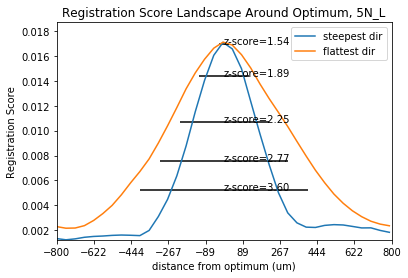

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 241.52676353  257.43318527  288.16017968] f: [ 241.52676353  257.43318527  288.16017968]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


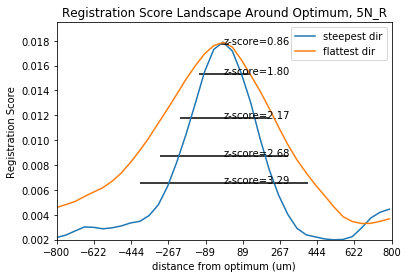

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 282.12774339  256.52504221  170.10185706] f: [ 282.12774339  256.52504221  170.10185706]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


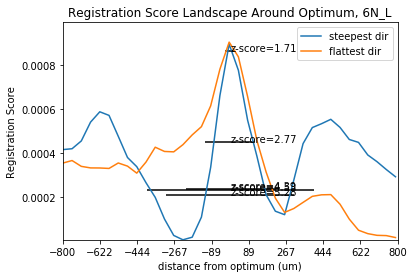

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 282.2424581   253.65307263  218.99273743] f: [ 282.2424581   253.65307263  218.99273743]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


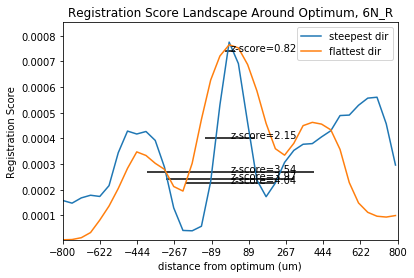

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 309.54096748  320.93823449  120.77705657] f: [ 309.54096748  320.93823449  120.77705657]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


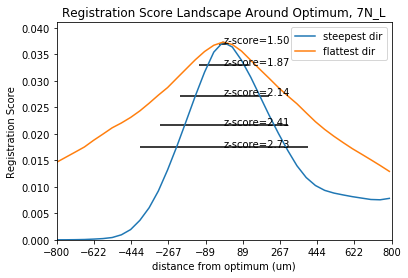

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 309.8139484   311.83507324  275.56293725] f: [ 309.8139484   311.83507324  275.56293725]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


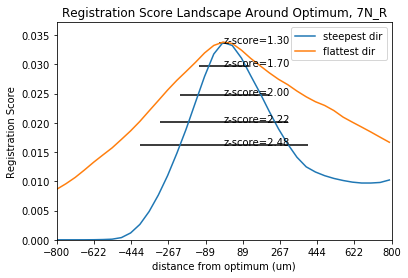

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 272.83870756  281.0801219   122.96559182] f: [ 272.83870756  281.0801219   122.96559182]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


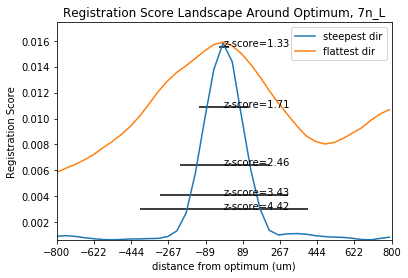

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 273.070885    272.52076363  269.00328019] f: [ 273.070885    272.52076363  269.00328019]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


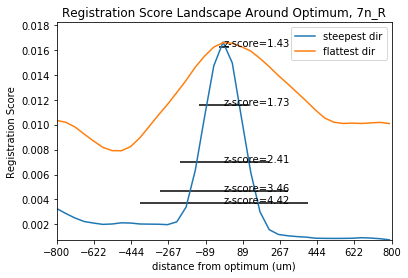

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 358.02871452  296.42971619  112.17295492] f: [ 358.02871452  296.42971619  112.17295492]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


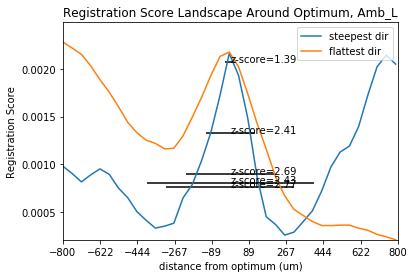

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 358.16364247  286.58266129  280.95564516] f: [ 358.16364247  286.58266129  280.95564516]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


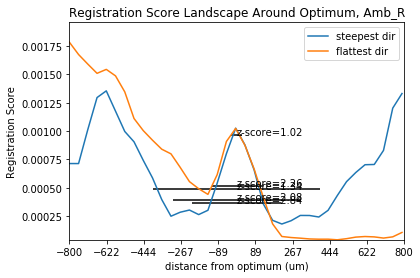

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 251.55632285  220.77083666  137.11270557] f: [ 251.55632285  220.77083666  137.11270557]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


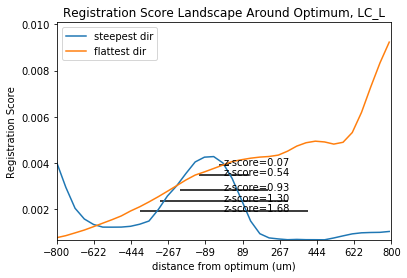

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 251.75071879  214.24305167  247.97342465] f: [ 251.75071879  214.24305167  247.97342465]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


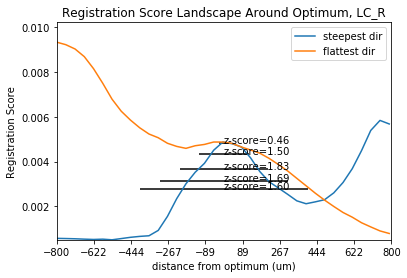

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 414.22821182  303.39115391  134.05077136] f: [ 414.22821182  303.39115391  134.05077136]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


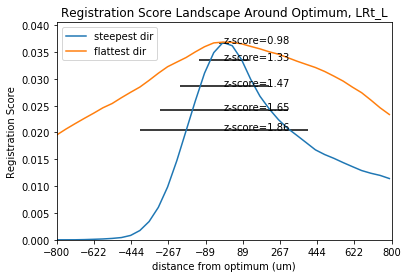

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 414.46789368  296.0024411   259.6274256 ] f: [ 414.46789368  296.0024411   259.6274256 ]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


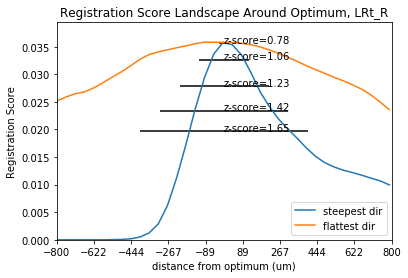

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 180.47570258  345.55096186  161.09467213] f: [ 180.47570258  345.55096186  161.09467213]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


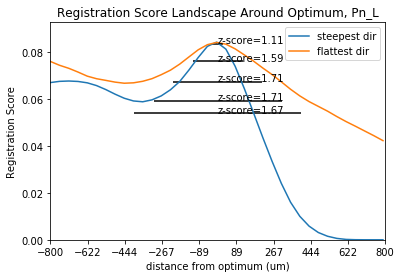

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 180.61289406  340.94445791  239.2490449 ] f: [ 180.61289406  340.94445791  239.2490449 ]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


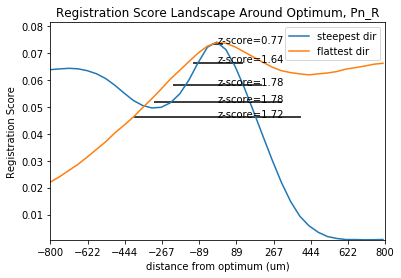

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 246.61669401  343.20431706  164.33162428] f: [ 246.61669401  343.20431706  164.33162428]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


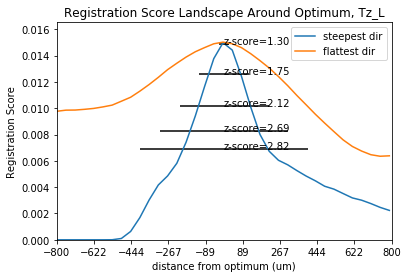

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 246.75236488  339.07199468  234.21802935] f: [ 246.75236488  339.07199468  234.21802935]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


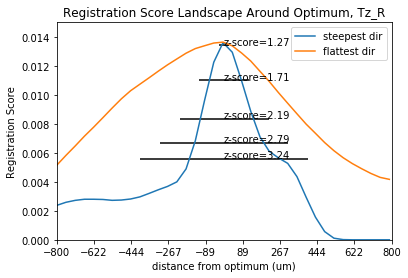

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 196.58185633  288.72258627   92.9572497 ] f: [ 196.58185633  288.72258627   92.9572497 ]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


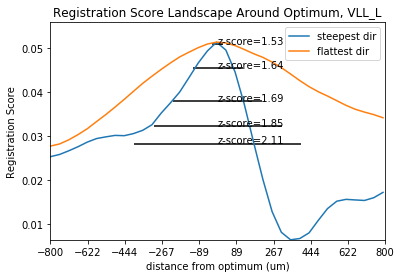

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 196.91696854  276.48755277  300.1562849 ] f: [ 196.91696854  276.48755277  300.1562849 ]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


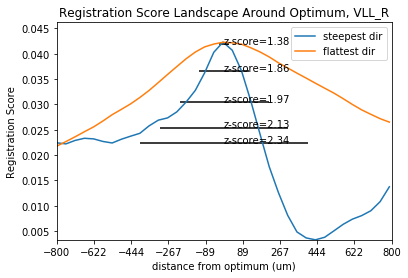

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 148.4286001   252.63863522  160.70496739] f: [ 148.4286001   252.63863522  160.70496739]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


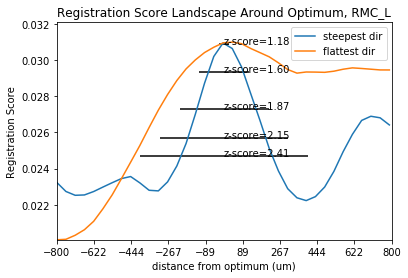

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 148.54874931  248.61123365  228.9518021 ] f: [ 148.54874931  248.61123365  228.9518021 ]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


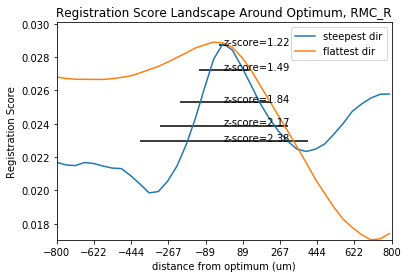

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 122.53938149  294.01812339  113.69875138] f: [ 122.53938149  294.01812339  113.69875138]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


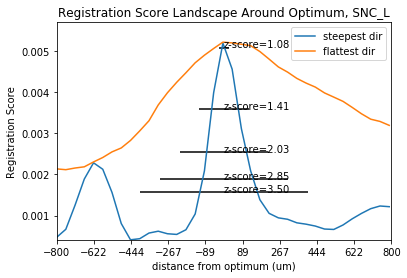

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 122.80876915  284.23639725  279.659271  ] f: [ 122.80876915  284.23639725  279.659271  ]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


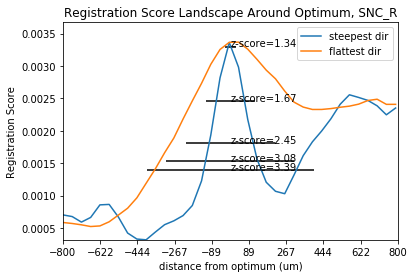

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 141.7883487   284.9134243   101.25432109] f: [ 141.7883487   284.9134243   101.25432109]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


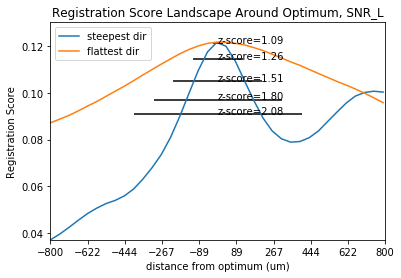

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 142.10117456  273.66653934  291.83907351] f: [ 142.10117456  273.66653934  291.83907351]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


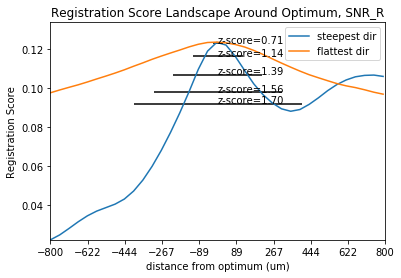

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 161.9494996   214.80536063  182.51777292] f: [ 161.9494996   214.80536063  182.51777292]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


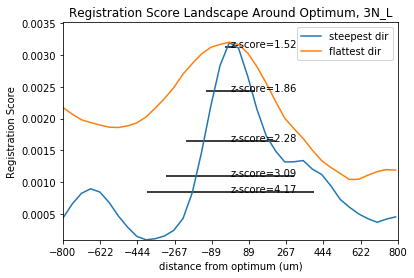

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 162.01527331  213.57510335  202.81511254] f: [ 162.01527331  213.57510335  202.81511254]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


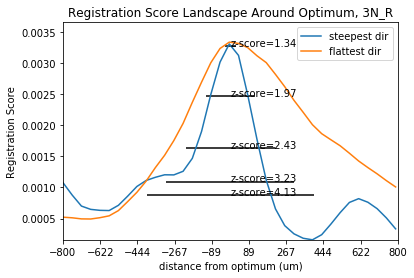

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 186.18309859  210.36205468  175.12096106] f: [ 186.18309859  210.36205468  175.12096106]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


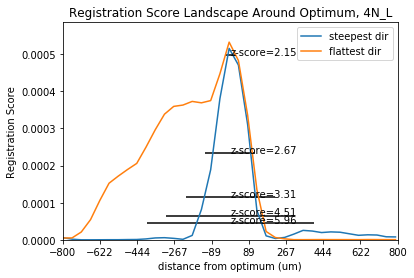

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 186.25894378  208.37052811  209.6746167 ] f: [ 186.25894378  208.37052811  209.6746167 ]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


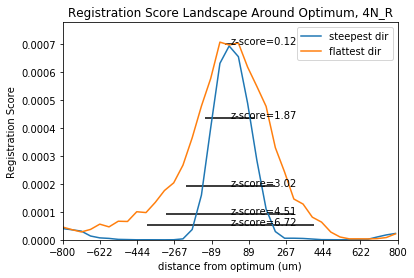

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 387.98083621  251.63684451   62.90716517] f: [ 387.98083621  251.63684451   62.90716517]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


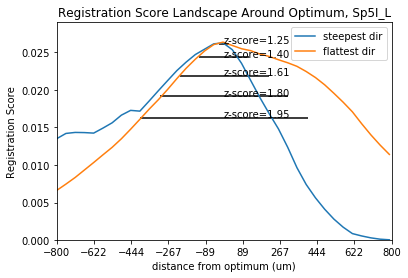

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 388.43245452  236.22516794  324.40723427] f: [ 388.43245452  236.22516794  324.40723427]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


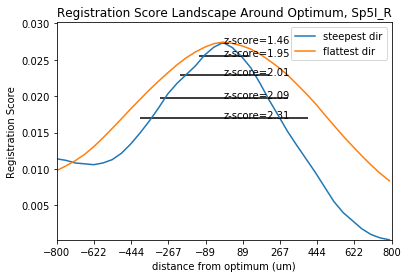

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 335.37698638  270.36057932   68.7824315 ] f: [ 335.37698638  270.36057932   68.7824315 ]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


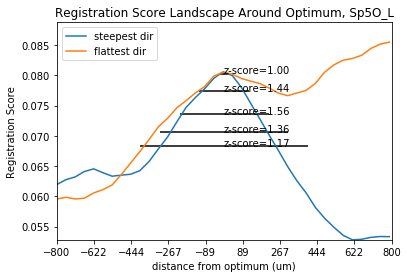

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 335.8219985   255.5427263   320.10829707] f: [ 335.8219985   255.5427263   320.10829707]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


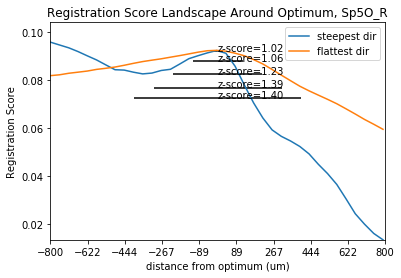

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 438.45257496  254.17274618   98.65791045] f: [ 438.45257496  254.17274618   98.65791045]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


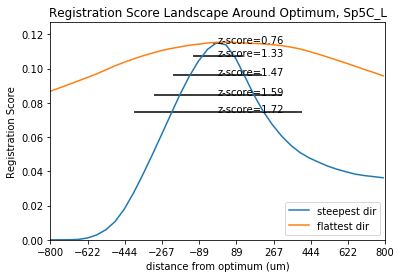

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 438.78062541  242.95270953  288.8644516 ] f: [ 438.78062541  242.95270953  288.8644516 ]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


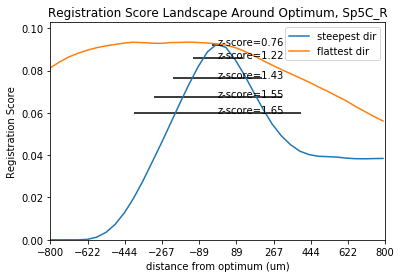

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 178.71884498  204.64189002   66.29068804] f: [ 178.71884498  204.64189002   66.29068804]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


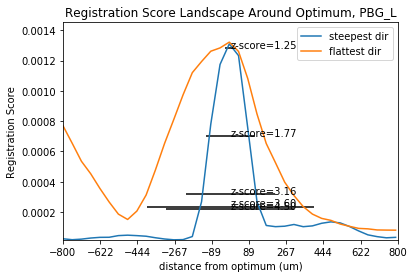

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 179.20948012  189.85460106  316.88990826] f: [ 179.20948012  189.85460106  316.88990826]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


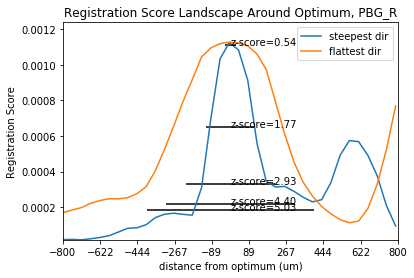

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 403.7607468   239.0021897   174.38676962] f: [ 403.7607468   239.0021897   174.38676962]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


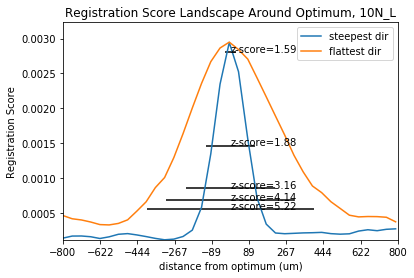

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 403.90735568  236.78340317  212.31017225] f: [ 403.90735568  236.78340317  212.31017225]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


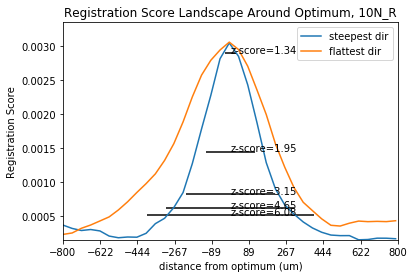

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 267.62269116  257.30523104   28.78225386] f: [ 267.62269116  257.30523104   28.78225386]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


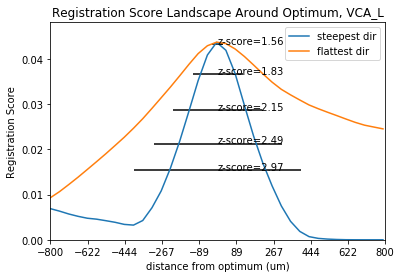

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 268.18257805  237.86310781  358.74177502] f: [ 268.18257805  237.86310781  358.74177502]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


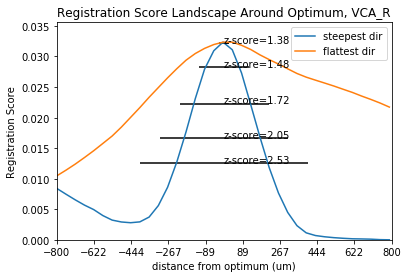

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 307.23302108  257.25951405   37.29435012] f: [ 307.23302108  257.25951405   37.29435012]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


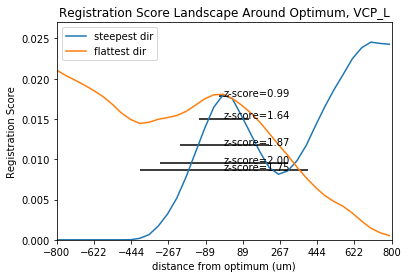

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 307.77349186  238.74653939  351.01691853] f: [ 307.77349186  238.74653939  351.01691853]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


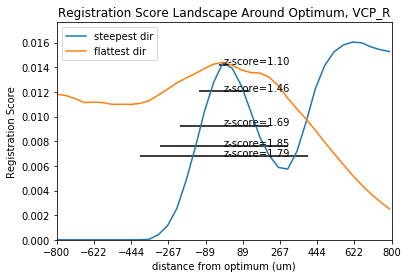

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 309.81469744  216.72138244   44.39357809] f: [ 309.81469744  216.72138244   44.39357809]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


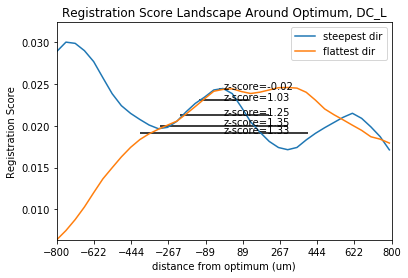

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 310.32059014  199.36683658  338.20180918] f: [ 310.32059014  199.36683658  338.20180918]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


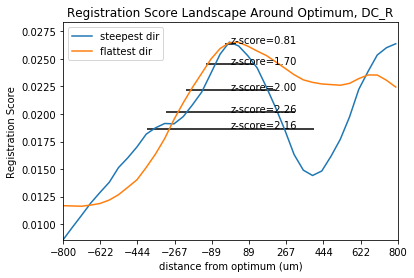

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 397.18472828  223.96692545  192.62671488] f: [ 397.18472828  223.96692545  192.62671488]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


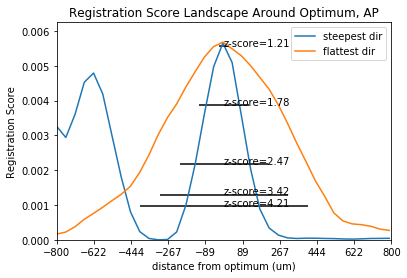

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 401.81007262  249.98365713  193.9745585 ] f: [ 401.81007262  249.98365713  193.9745585 ]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


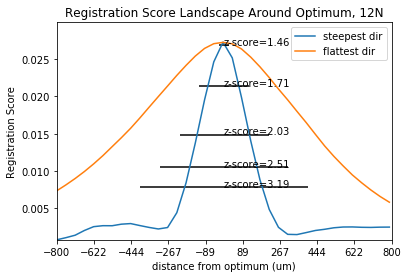

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 205.22237628  317.53367045  198.62264271] f: [ 205.22237628  317.53367045  198.62264271]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


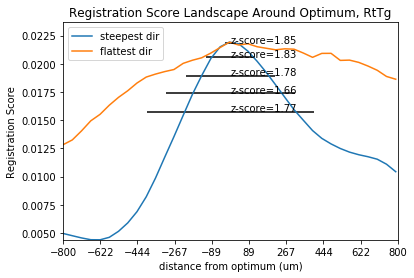

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Child returned 0


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp


Child returned 1
0.36 seconds.
File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp
Score volume for sp5 does not exist.
Error sp5:list index out of range
File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Child returned 0


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp


Child returned 1
0.36 seconds.
File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp
Score volume for outerContour does not exist.
Error outerContour:list index out of range
File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 141.62347339  135.84237371  188.40012208] f: [ 141.62347339  135.84237371  188.40012208]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


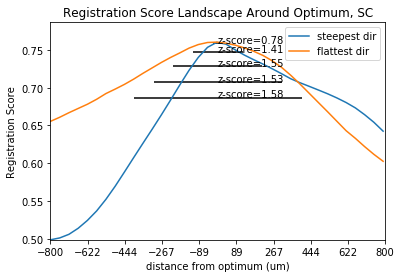

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (445, 655, 397)


m: [ 211.61283808  105.189224    185.77682554] f: [ 211.61283808  105.189224    185.77682554]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


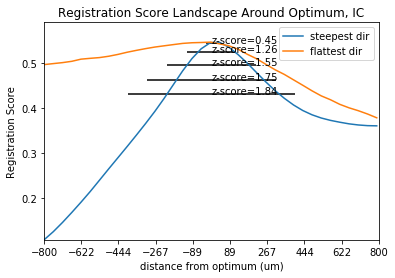

In [308]:
# structure = 'AP'
# for structure in ['AP', '7N_L', '5N_R', 'LRt_R', '12N', '10N_L']:
for structure in all_known_structures_sided:
    
    try:

        # Initialize Aligner object

        volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
            DataManager.load_original_volume_all_known_structures(stack=stack_fixed, 
                                                                  classifier_setting=classifier_setting,
                                                                 sided=False, volume_type='score',
                                                                 structures=[convert_to_original_name(structure)])

        if include_surround:
            volume_moving = DataManager.load_transformed_volume_all_known_structures(stack_m=stack_moving, stack_f=stack_fixed,
                                                                         classifier_setting_m=classifier_setting,
                                                                         classifier_setting_f=classifier_setting,
                                                                         warp_setting=upstream_warp_setting, 
                                                                         structures=[structure, 
                                                                                     convert_to_surround_name(structure, margin='200')])
        else:
            volume_moving = DataManager.load_transformed_volume_all_known_structures(stack_m=stack_moving, stack_f=stack_fixed,
                                                                         classifier_setting_m=classifier_setting,
                                                                         classifier_setting_f=classifier_setting,
                                                                         warp_setting=upstream_warp_setting, 
                                                                         structures=[structure])

        structure_to_label_moving = {s: l+1 for l, s in enumerate(sorted(volume_moving.keys()))}
        label_to_structure_moving = {l+1: s for l, s in enumerate(sorted(volume_moving.keys()))}
        volume_moving = {structure_to_label_moving[s]: v for s, v in volume_moving.items()}

        label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                             for label_m, name_m in label_to_structure_moving.iteritems()}

        if surround_weight == 'inverse':
            volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}
            label_weights_m = {label_m: -volume_moving_structure_sizes[structure_to_label_moving[convert_to_nonsurround_name(name_m)]]
                               /float(volume_moving_structure_sizes[label_m])
                               if is_surround_label(name_m) else 1. \
                               for label_m, name_m in label_to_structure_moving.iteritems()}
        elif isinstace(surround_weight, int) or isinstace(surround_weight, float):
            label_weights_m = {label_m: surround_weight if is_surround_label(name_m) else 1. \
                               for label_m, name_m in label_to_structure_moving.iteritems()}
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

        aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

        aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', 
                             indices_m=[structure_to_label_moving[structure]])                            

        aligner.set_regularization_weights(reg_weights)
        aligner.set_label_weights(label_weights_m)


        # Compute steepest and flattest directions based on the Hessian matrix.

        # Specify a step size.
        stepsize = hessian_stepsize_list[2]
        H, _ = hessians_all_stacks_all_structures_all_stepsizes['MD635'][structure][stepsize]
        U, S, UT = np.linalg.svd(H)
        steepest_direction = U[:,0]
        flattest_direction = U[:,-1]

        # Specify sample points.
        max_pooling_radius_um = 800
        max_pooling_radius_pixel = max_pooling_radius_um / xy_pixel_distance
        grid_size = 3
        waypoints = np.arange(-max_pooling_radius_pixel, max_pooling_radius_pixel, grid_size)
        dxdydzs_steepest_dir = np.outer(waypoints, steepest_direction)
        dxdydzs_flattest_dir = np.outer(waypoints, flattest_direction)

        # Compute a slice of the score function around the optimal estimate, along both the steepest and flattest directions.

        tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
                    DataManager.load_alignment_parameters(stack_m=stack_moving, stack_f=stack_fixed,
                                                          classifier_setting_m=classifier_setting,
                                                          classifier_setting_f=classifier_setting,
                                                          warp_setting=warp_setting,
                                                          param_suffix=structure)

        labels_for_computing_confidence = [structure_to_label_moving[structure]]

        neighbor_scores_slice_steepest_dir = aligner.compute_scores_neighborhood_samples(tx_params, dxs=dxdydzs_steepest_dir[:,0], 
                                                                      dys=dxdydzs_steepest_dir[:,1], 
                                                                      dzs=dxdydzs_steepest_dir[:,2],
                                                                   indices_m=labels_for_computing_confidence)

        neighbor_scores_slice_flattest_dir = aligner.compute_scores_neighborhood_samples(tx_params, 
                                                                                         dxs=dxdydzs_flattest_dir[:,0], 
                                                                      dys=dxdydzs_flattest_dir[:,1], 
                                                                      dzs=dxdydzs_flattest_dir[:,2],
                                                                   indices_m=labels_for_computing_confidence)

        # Plot
        plt.figure();

        plt.plot(waypoints * xy_pixel_distance, neighbor_scores_slice_steepest_dir, label='steepest dir')
        plt.plot(waypoints * xy_pixel_distance, neighbor_scores_slice_flattest_dir, label='flattest dir')

        ymin = np.min(np.r_[neighbor_scores_slice_steepest_dir, neighbor_scores_slice_flattest_dir])
        ymax = np.max(np.r_[neighbor_scores_slice_steepest_dir, neighbor_scores_slice_flattest_dir])
        plt.ylim([ymin, ymax+(ymax-ymin)*.1]);
        plt.xlim([-max_pooling_radius_um, max_pooling_radius_um]);
        plt.title('Registration Score Landscape Around Optimum, %s' % structure)
        plt.ylabel('Registration Score');
        plt.xlabel('distance from optimum (um)');
        plt.legend()
        plt.xticks(np.linspace(-max_pooling_radius_um, max_pooling_radius_um, 10));

        for poolradius_um, (z, fmax, mean, std) in zscores_all_stacks_all_structures['MD635'][structure].iteritems():
            plt.hlines(mean, -poolradius_um, poolradius_um);
            plt.text(x=0, y=mean, s='z-score=%.2f'%z, fontsize=10);

        plt.show();
        
#         landscape_plot_fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed, 
#                                                classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
#                                                warp_setting=warp_setting,
#                                                 param_suffix=structure,
#                                                what='score_landscape')
#         plt.savefig(landscape_plot_fp, bbox_inches='tight')
        
    except Exception as e:
        sys.stderr.write('Error %s:' % structure + str(e) + '\n')

# Compute Peak Radius for all structures in all stacks

In [310]:
stack_moving = 'atlasV3'

In [311]:
classifier_setting = 37
warp_setting = 8

In [312]:
downscale = 32
xy_pixel_distance = XY_PIXEL_DISTANCE_LOSSLESS * downscale

In [319]:
peak_radius_all_stacks_all_structures = defaultdict(dict)

# for stack_fixed in all_nissl_stacks:
for stack_fixed in ['MD635']:

    for structure in all_known_structures_sided:
        try:
            
            # Compute peak radius using hessian and z-score.

            peak_radius = defaultdict(dict)
            for poolradius_um, (zscore, fmax, mu, std) in zscores_all_stacks_all_structures[stack_fixed][structure].iteritems():
                for stepsize_um, (H, fmax) in hessians_all_stacks_all_structures_all_stepsizes[stack_fixed][structure].iteritems():
                    if poolradius_um > stepsize_um * 2:  # compute only if pooling radius is at least twice the step size
                        U, S, UT = np.linalg.svd(H)

                        # using the smallest eigenvalues of Hessians (flattest direction), drop to mean
                        peak_radius_pixel_max = np.sqrt(2*(fmax-mu)/S[-1])

                        # using the largest eigenvalues of Hessians (steepest direction), drop to mean
                        peak_radius_pixel_min = np.sqrt(2*(fmax-mu)/S[0])

                        # using the largest eigenvalues of Hessians, drop to 2-sigma
                        peak_radius_pixel_2sigma = np.sqrt(2*(fmax-(mu+2*std))/S[0])

                        peak_radius[poolradius_um][stepsize_um] = (peak_radius_pixel_max * xy_pixel_distance,
                                                                  peak_radius_pixel_min * xy_pixel_distance,
                                                                  peak_radius_pixel_2sigma * xy_pixel_distance)
            peak_radius.default_factory = None

            peak_radius_all_stacks_all_structures[stack_fixed][structure] = peak_radius

        except Exception as e:
            sys.stderr.write('Error %s:' % structure + str(e) + '\n')
                
peak_radius_all_stacks_all_structures.default_factory = None

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt
Error sp5:'sp5'
Error outerContour:'outerContour'


In [320]:
pooling_radius_list = sorted(zscores.keys())
print 'pooling radius:', pooling_radius_list
hessian_stepsize_list = sorted(hessians_all_stepsizes.keys())
print 'hessian stepsize:', hessian_stepsize_list

pooling radius: [25.0, 118.75, 212.5, 306.25, 400.0]
hessian stepsize: [14.72, 84.64, 154.56, 224.48000000000002, 294.40000000000003]


# Plot peak radius of different structures in one stack

In [325]:
# Choose one set of meta parameters.

pool_radius = pooling_radius_list[2]
hessian_stepsize = hessian_stepsize_list[1]

In [327]:
structures_sided_sorted_by_size = ['4N_L', '4N_R', '6N_L', '6N_R', 'Amb_L', 'Amb_R', 'PBG_L', 'PBG_R', '10N_L', '10N_R', 'AP', '3N_L', '3N_R', 'LC_L', 'LC_R', 'SNC_L', 'SNC_R', 'Tz_L', 'Tz_R', '7n_L', '7n_R', 'RMC_L', 'RMC_R', '5N_L', '5N_R', 'VCP_L', 'VCP_R', '12N', 'LRt_L', 'LRt_R', '7N_L', '7N_R', 'VCA_L', 'VCA_R', 'VLL_L', 'VLL_R', 'DC_L', 'DC_R', 'Sp5O_L', 'Sp5O_R', 'Sp5I_L', 'Sp5I_R', 'Pn_L', 'Pn_R', 'RtTg', 'SNR_L', 'SNR_R', 'Sp5C_L', 'Sp5C_R', 'IC', 'SC']

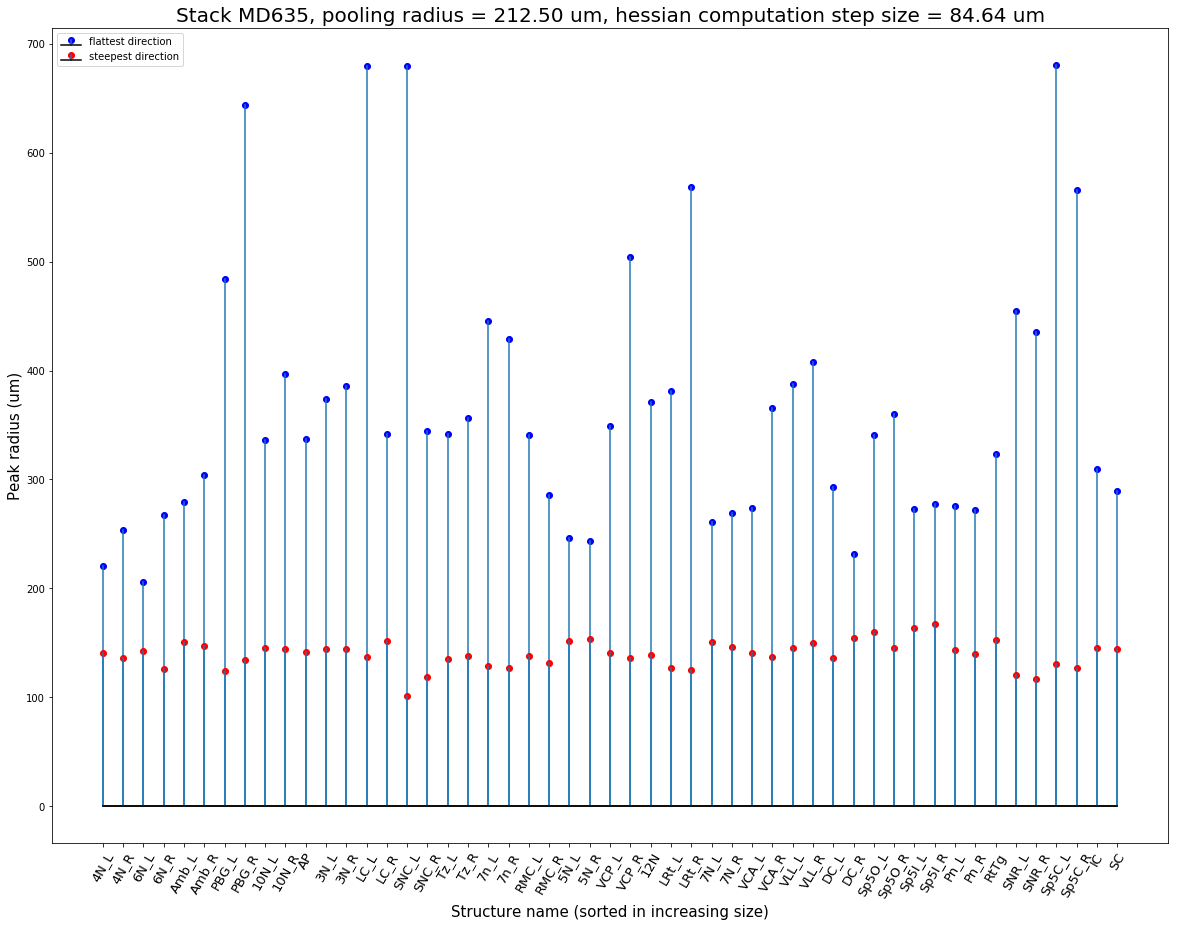

In [342]:
D = np.array([peak_radius_all_stacks_all_structures['MD635'][s][pool_radius][hessian_stepsize][:2]
     for s in structures_sided_sorted_by_size])

plt.figure(figsize=(20, 15));
plt.stem(range(1, len(structures_sided_sorted_by_size)+1), D[:,0], label='flattest direction', markerfmt='bo', basefmt='k');
plt.stem(range(1, len(structures_sided_sorted_by_size)+1), D[:,1], label='steepest direction', markerfmt='ro', basefmt='k');
plt.xticks(range(1, len(structures_sided_sorted_by_size)+1), structures_sided_sorted_by_size, 
           rotation='60', fontsize=13);
plt.xlabel('Structure name (sorted in increasing size)', fontsize=15);
plt.ylabel('Peak radius (um)', fontsize=15);
plt.title('Stack %s, pooling radius = %.2f um, hessian computation step size = %.2f um' % (stack_fixed, pool_radius, hessian_stepsize), fontsize=20);
plt.legend();

# Plot z-scores of different structures for all stacks

In [344]:
# Choose one set of meta parameters.

pool_radius = pooling_radius_list[1]
hessian_stepsize = hessian_stepsize_list[0]

In [345]:
zsocres_all_structures_all_stacks_one_poolingRadius = defaultdict(dict)
for st, zs_all_structs in zscores_all_stacks_all_structures.iteritems():
    for struct, zs in zs_all_structs.iteritems():
        zsocres_all_structures_all_stacks_one_poolingRadius[struct][st] = zs[pool_radius][0]
        
zsocres_all_structures_all_stacks_one_poolingRadius.default_factory = None

In [346]:
structures_sided_sorted_by_size = ['4N_L', '4N_R', '6N_L', '6N_R', 'Amb_L', 'Amb_R', 'PBG_L', 'PBG_R', '10N_L', '10N_R', 'AP', '3N_L', '3N_R', 'LC_L', 'LC_R', 'SNC_L', 'SNC_R', 'Tz_L', 'Tz_R', '7n_L', '7n_R', 'RMC_L', 'RMC_R', '5N_L', '5N_R', 'VCP_L', 'VCP_R', '12N', 'LRt_L', 'LRt_R', '7N_L', '7N_R', 'VCA_L', 'VCA_R', 'VLL_L', 'VLL_R', 'DC_L', 'DC_R', 'Sp5O_L', 'Sp5O_R', 'Sp5I_L', 'Sp5I_R', 'Pn_L', 'Pn_R', 'RtTg', 'SNR_L', 'SNR_R', 'Sp5C_L', 'Sp5C_R', 'IC', 'SC']

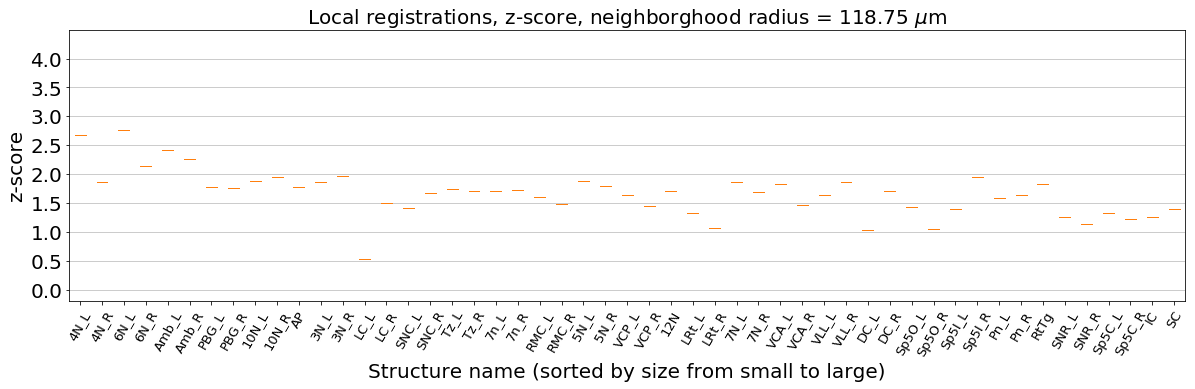

In [348]:
plt.figure(figsize=(20, 5));

D = [zsocres_all_structures_all_stacks_one_poolingRadius[s].values() 
     for s in structures_sided_sorted_by_size]

plt.boxplot(D);
plt.xticks(range(1, len(structures_sided_sorted_by_size)+1), structures_sided_sorted_by_size, 
           rotation='60', fontsize=13);
plt.yticks(np.arange(0, 4.5, .5), map(str, np.arange(0, 4.5, .5)), fontsize=20);
plt.ylim([-.2,4.5]);
plt.xlabel('Structure name (sorted by size from small to large)', fontsize=20);
plt.ylabel('z-score', fontsize=20);
# plt.title('z-score', fontsize=20);
plt.title('Local registrations, z-score, neighborghood radius = %.2f $\mu$m' % (pool_radius), fontsize=20);

plt.gca().yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.5)
# Hide these grid behind plot objects
plt.gca().set_axisbelow(True)

In [350]:
np.mean(D)

1.6615093907277323

# Plot peak radius of different structures for all stacks

In [352]:
# Choose one set of meta parameters.

pool_radius = pooling_radius_list[1]
hessian_stepsize = hessian_stepsize_list[0]
print pool_radius
print hessian_stepsize

118.75
14.72


In [354]:
peak_radius_max_oneCombination = defaultdict(dict)
peak_radius_min_oneCombination = defaultdict(dict)
for stack, x_per_stack in peak_radius_all_stacks_all_structures.iteritems():
    for struct, x in x_per_stack.iteritems():
        prmax, prmin, pr2sigma = x[pool_radius][hessian_stepsize]
        peak_radius_min_oneCombination[struct][stack] = prmin
        peak_radius_max_oneCombination[struct][stack] = prmax

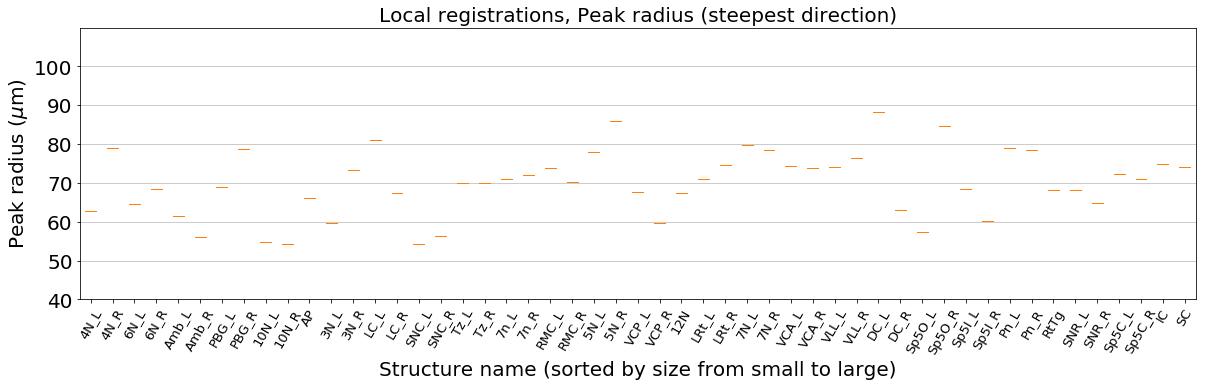

In [355]:
plt.figure(figsize=(20, 5));

D = [peak_radius_min_oneCombination[struct].values() for struct in structures_sided_sorted_by_size]
plt.boxplot(D);
plt.ylim([40, 110]);
plt.xticks(range(1, len(structures_sided_sorted_by_size)+1), structures_sided_sorted_by_size, rotation='60', fontsize=13);
plt.xlabel('Structure name (sorted by size from small to large)', fontsize=20);
plt.yticks(np.arange(40, 110, 10), map(str, np.arange(40, 110, 10)), fontsize=20);
plt.ylabel('Peak radius ($\mu$m)', fontsize=20);
plt.title('Local registrations, Peak radius (steepest direction)', fontsize=20);

plt.gca().yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.5)
# Hide these grid behind plot objects
plt.gca().set_axisbelow(True)

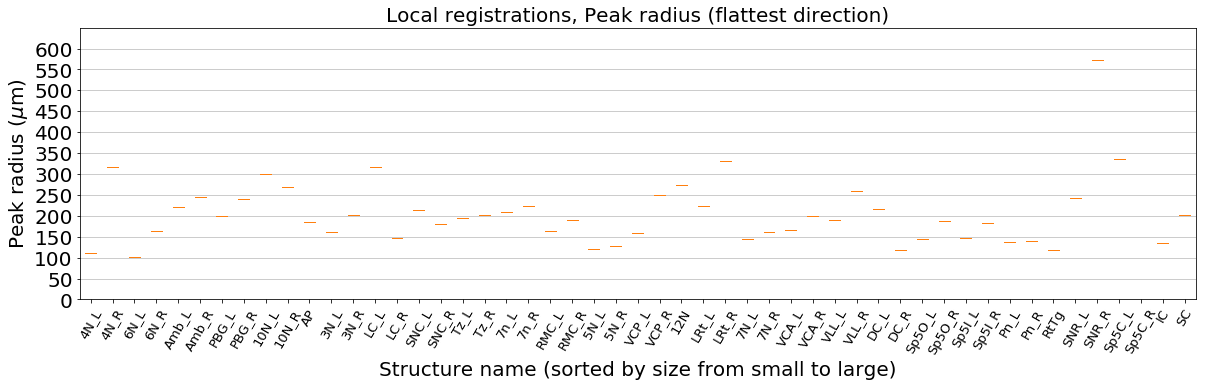

In [356]:
plt.figure(figsize=(20, 5));

D = [peak_radius_max_oneCombination[struct].values() for struct in structures_sided_sorted_by_size]
plt.boxplot(D);
plt.ylim([0, 650]);
plt.xticks(range(1, len(structures_sided_sorted_by_size)+1), structures_sided_sorted_by_size, rotation='60', fontsize=13);
plt.xlabel('Structure name (sorted by size from small to large)', fontsize=20);
plt.yticks(np.arange(0, 650, 50), map(str, np.arange(0, 650, 50)), fontsize=20);
plt.ylabel('Peak radius ($\mu$m)', fontsize=20);
plt.title('Local registrations, Peak radius (flattest direction)', fontsize=20);

plt.gca().yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.5)
# Hide these grid behind plot objects
plt.gca().set_axisbelow(True)

# Put both flattest / steepest directions in one figure

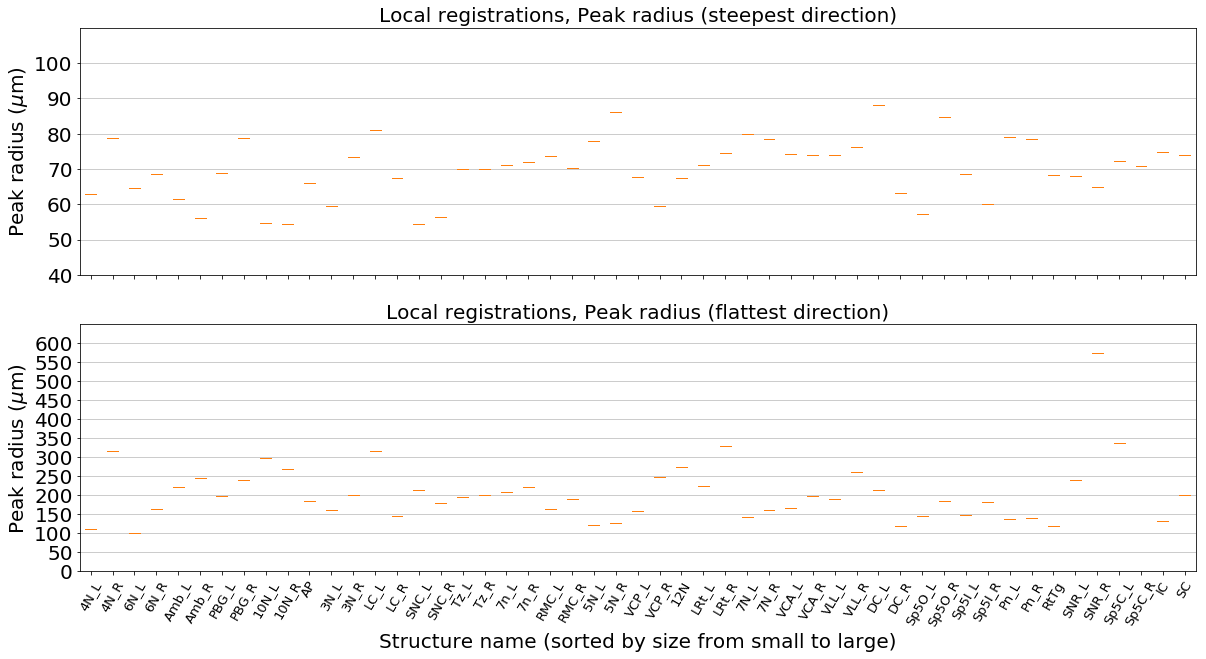

In [357]:
fig, axes = plt.subplots(2, 1, figsize=(20,10), sharex=True);

D = [peak_radius_min_oneCombination[struct].values() for struct in structures_sided_sorted_by_size]
axes[0].boxplot(D);
axes[0].set_ylim([40, 110]);

axes[0].set_yticks(np.arange(40, 110, 10));
axes[0].set_yticklabels(map(str, np.arange(40, 110, 10)), fontsize=20);
axes[0].set_ylabel('Peak radius ($\mu$m)', fontsize=20);
axes[0].set_title('Local registrations, Peak radius (steepest direction)', fontsize=20);

axes[0].yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.5)
# Hide these grid behind plot objects
axes[0].set_axisbelow(True)

D = [peak_radius_max_oneCombination[struct].values() for struct in structures_sided_sorted_by_size]
axes[1].boxplot(D);
axes[1].set_ylim([0, 650]);
axes[1].set_yticks(np.arange(0, 650, 50));
axes[1].set_yticklabels(map(str, np.arange(0, 650, 50)), fontsize=20);
axes[1].set_ylabel('Peak radius ($\mu$m)', fontsize=20);
axes[1].set_title('Local registrations, Peak radius (flattest direction)', fontsize=20);

axes[1].yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.5)
# Hide these grid behind plot objects
axes[1].set_axisbelow(True)

plt.xticks(range(1, len(structures_sided_sorted_by_size)+1), structures_sided_sorted_by_size, rotation='60', fontsize=13);
plt.xlabel('Structure name (sorted by size from small to large)', fontsize=20);

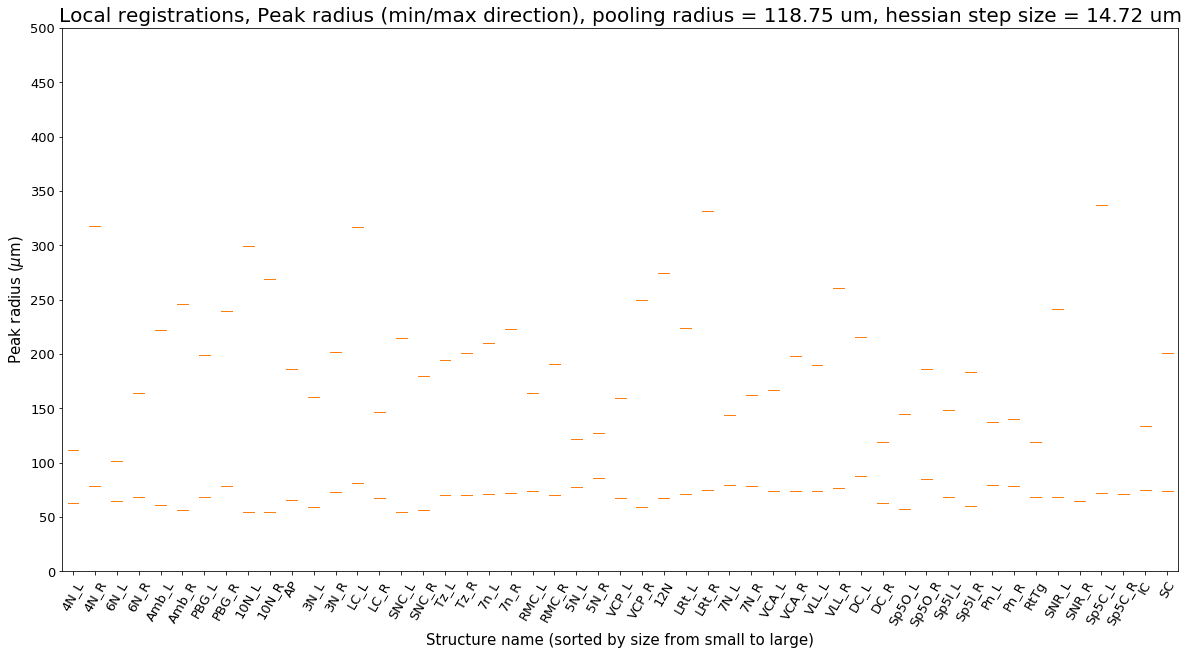

In [358]:
plt.figure(figsize=(20, 10));

D = [peak_radius_min_oneCombination[struct].values() for struct in structures_sided_sorted_by_size]

# plt.figure(figsize=(20, 15));
# # plt.stem(range(1, len(boxplot_labels)+1), D);
plt.boxplot(D);
# # plt.ylim([26, 42]);
# plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
# plt.xlabel('Structure name', fontsize=15);
# plt.ylabel('Peak radius (um)', fontsize=15);
# plt.title('Peak radius min, pooling radius = %.2f um, hessian step size = %.2f um' % (pool_radius, hessian_stepsize), fontsize=20);

###########################        

D = [peak_radius_max_oneCombination[struct].values() for struct in structures_sided_sorted_by_size]

# plt.figure(figsize=(20, 15));
# plt.stem(range(1, len(boxplot_labels)+1), D);
plt.boxplot(D);
plt.ylim([0, 500]);
plt.xticks(range(1, len(structures_sided_sorted_by_size)+1), structures_sided_sorted_by_size, rotation='60', fontsize=13);
plt.xlabel('Structure name (sorted by size from small to large)', fontsize=15);
plt.yticks(np.arange(0, 550, 50), map(str, np.arange(0, 550, 50)), fontsize=13);
plt.ylabel('Peak radius ($\mu$m)', fontsize=15);
plt.title('Local registrations, Peak radius (min/max direction), pooling radius = %.2f um, hessian step size = %.2f um' % (pool_radius, hessian_stepsize), fontsize=20);

In [29]:
def plot_peak_radius(peak_radius):
    for poolradius_um, v in peak_radius.iteritems():
        xs, ys_max_min = zip(*sorted(v.items()))
        ys_max, ys_min = zip(*ys_max_min)
        c = np.array(random_colors(1)[0])/255.
        plt.plot(xs, ys_max, linestyle='-', color=c, label='pool=%dum, max' % poolradius_um);
        plt.plot(xs, ys_min, linestyle='--', color=c, label='pool=%dum, min' % poolradius_um);
    plt.legend(loc='lower right');
    plt.xlabel('Hessian step size (um)');
    plt.ylabel('Peak radius (um)');
    plt.show();

# OLD CODE

In [ ]:
# peak radius computed using largest eigenvalue

peak_radius_allStructures = {}
zscores_allStructures = {}

for name_s in structures_sided:
        
#     hessian_fp = DataManager.get_hessian_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
#                                         moving_volume_type='score', fixed_volume_type='score', 
#                                         label=name_s,
#                                         train_sample_scheme=train_sample_scheme, 
#                                         global_transform_scheme=global_transform_scheme, 
#                                         local_transform_scheme=local_transform_scheme)  
#     hessians = load_pickle(hessian_fp)
    
#     zscore_fp = DataManager.get_zscore_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
#                                         moving_volume_type='score', fixed_volume_type='score', 
#                                         label=name_s,
#                                         train_sample_scheme=train_sample_scheme, 
#                                         global_transform_scheme=global_transform_scheme, 
#                                         local_transform_scheme=local_transform_scheme)
#     zscores = load_pickle(zscore_fp)
    
    zscores_allStructures[name_s] = zscores
    
    ###################################################
        
    peak_radius = {}
        
    for pooling_radius, (zscore, fmax, mu, std) in zscores.iteritems():
        
        peak_radius[pooling_radius] = {}
        
        for step_size, (H, fmax) in hessians.iteritems():
            if pooling_radius > step_size * 2:  # compute only if pooling radius is at least twice the step size
                U, S, UT = np.linalg.svd(H)
                peak_radius[pooling_radius][step_size] = np.sqrt(2*(fmax-mu)/S[0])

    peak_radius_allStructures[name_s] = peak_radius

In [ ]:
# Compute peak radius using the largest eigenvalues of Hessians

for pooling_radius, (zscore, fmax, mu, std) in zscores.iteritems():
    peak_radius[pooling_radius] = {}
    for step_size, (H, fmax) in Hs.iteritems():
        if pooling_radius > step_size * 2:  # compute only if pooling radius is at least twice the step size
            U, S, UT = np.linalg.svd(H)
            peak_radius[pooling_radius][step_size] = np.sqrt(2*(fmax-mu)/S[0])

peak_radius_allStructures[name_s] = peak_radius

# Compute peak radius using the smallest eigenvalues of Hessians

for pooling_radius, (zscore, fmax, mu, std) in zscores.iteritems():
    peak_radius[pooling_radius] = {}
    for step_size, (H, fmax) in Hs.iteritems():
        if pooling_radius > step_size * 2:  # compute only if pooling radius is at least twice the step size
            U, S, UT = np.linalg.svd(H)
            peak_radius[pooling_radius][step_size] = np.sqrt(2*(fmax-mu)/S[-1])

peak_radius_allStructures[name_s] = peak_radius

# Local

In [ ]:
#END

In [ ]:
fp = DataManager.get_hessian_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                        moving_volume_type='score', fixed_volume_type='score', 
                                        label=name_s,
                                        train_sample_scheme=train_sample_scheme, 
                                        global_transform_scheme=global_transform_scheme, 
                                        local_transform_scheme=local_transform_scheme)
    
hessians = load_pickle(fp)

In [15]:
zscores_allStructures = {}

for name_s in structures_sided:
    
    fp = DataManager.get_zscore_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                    moving_volume_type='score', fixed_volume_type='score', 
                                    label=name_s,
                                    train_sample_scheme=train_sample_scheme, 
                                    global_transform_scheme=global_transform_scheme, 
                                    local_transform_scheme=local_transform_scheme)

    zscores = load_pickle(fp)
    
    zscores_allStructures[name_s] = zscores

In [16]:
pooling_radius_list = sorted(zscores_allStructures['7N_L'].keys())

In [17]:
D = np.array([[z[0] for r, z in d.items()] for n, d in sorted(zscores_allStructures.items())])

In [18]:
boxplot_labels = sorted(zscores_allStructures.keys())

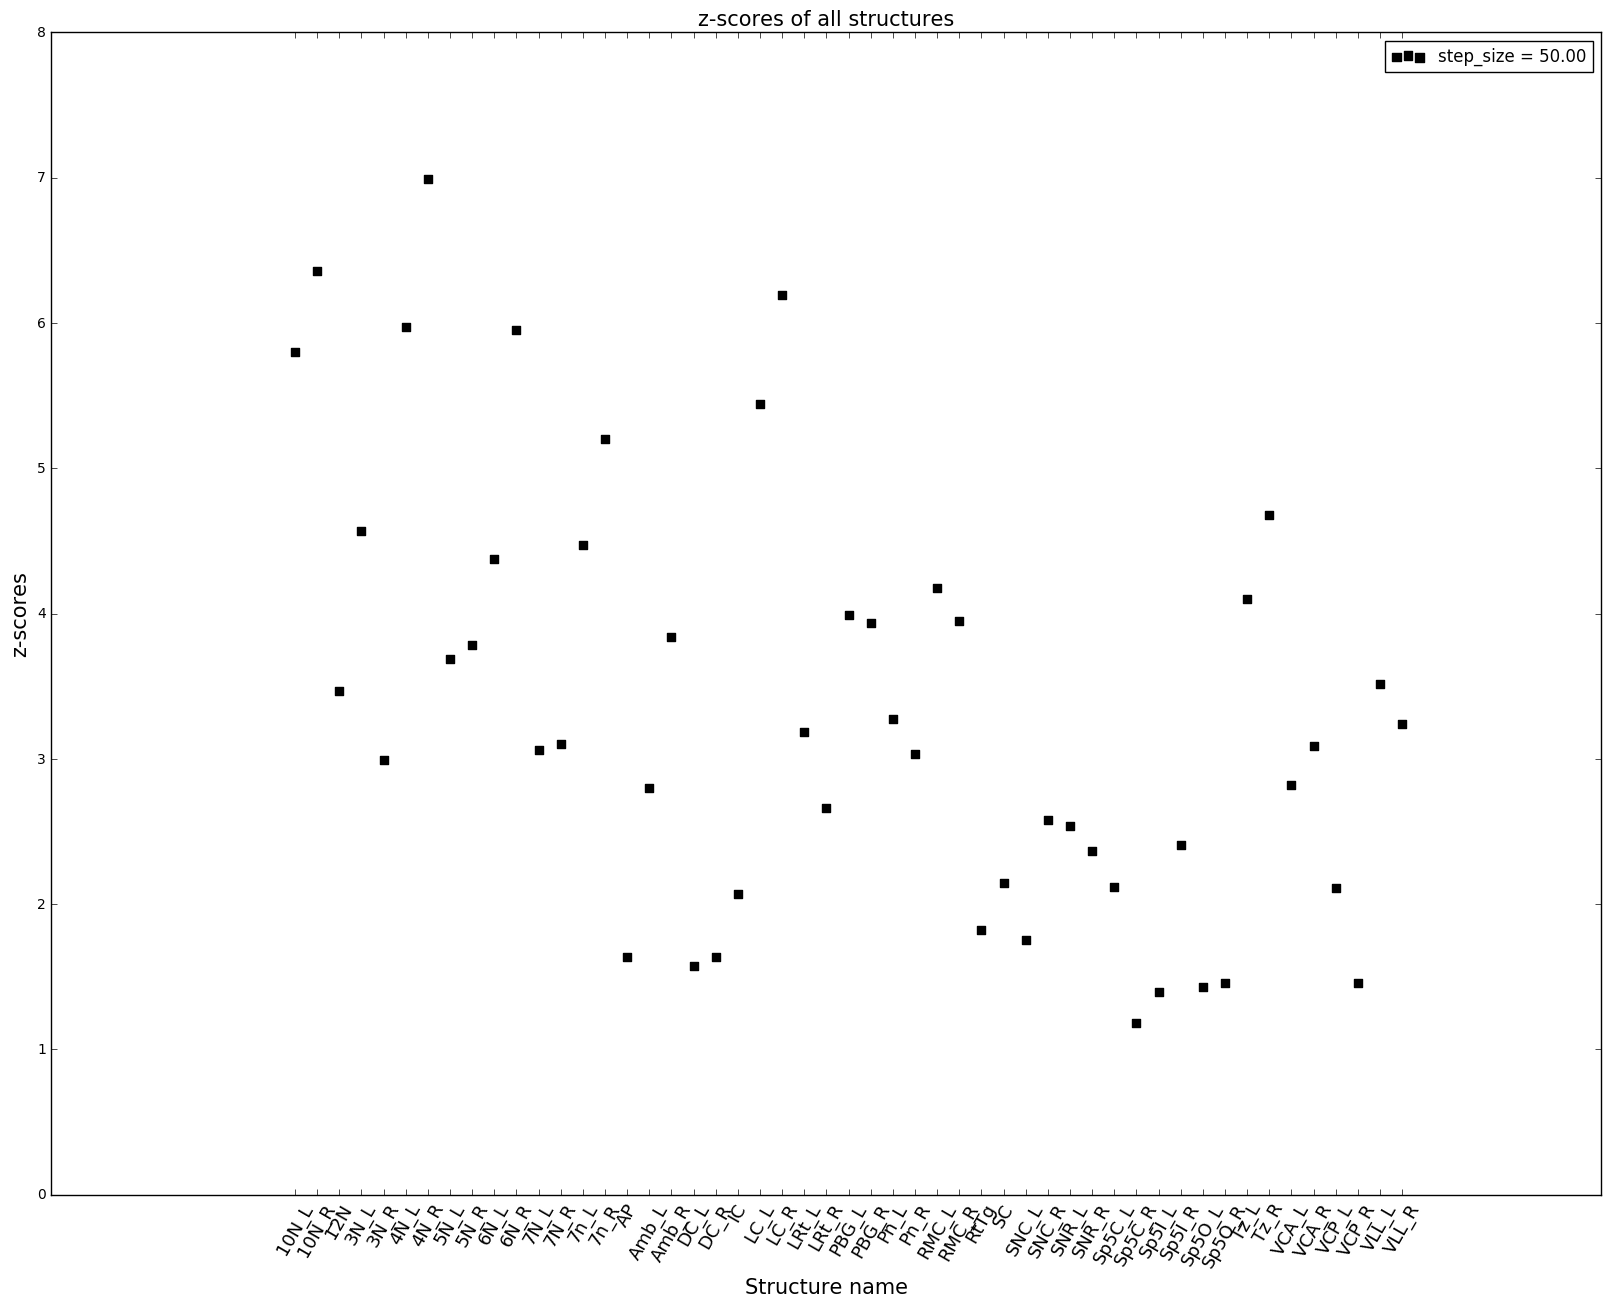

In [41]:
fig = plt.figure(figsize=(20, 15));
# fig, axes = plt.subplots(4, 1, figsize=(20, 30), sharex=False, sharey=True);

# plt.scatter(range(1, len(boxplot_labels)+1), D[:,0], marker='o', s=40, c='b', label='step_size = %.2f' % pooling_radius_list[0]);
# plt.scatter(range(1, len(boxplot_labels)+1), D[:,1], marker='^', s=40, c='g', label='step_size = %.2f' % pooling_radius_list[1]);
# plt.scatter(range(1, len(boxplot_labels)+1), D[:,2], marker='*', s=40, c='r', label='step_size = %.2f' % pooling_radius_list[2]);
plt.scatter(range(1, len(boxplot_labels)+1), D[:,3], marker='s', s=40, c='k', label='step_size = %.2f' % pooling_radius_list[3]);

plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name', fontsize=15);
# plt.yticks(np.arange(0.2, 5, .1), fontsize=15);
plt.ylabel('z-scores', fontsize=15);
plt.title('z-scores of all structures', fontsize=15);
plt.legend();

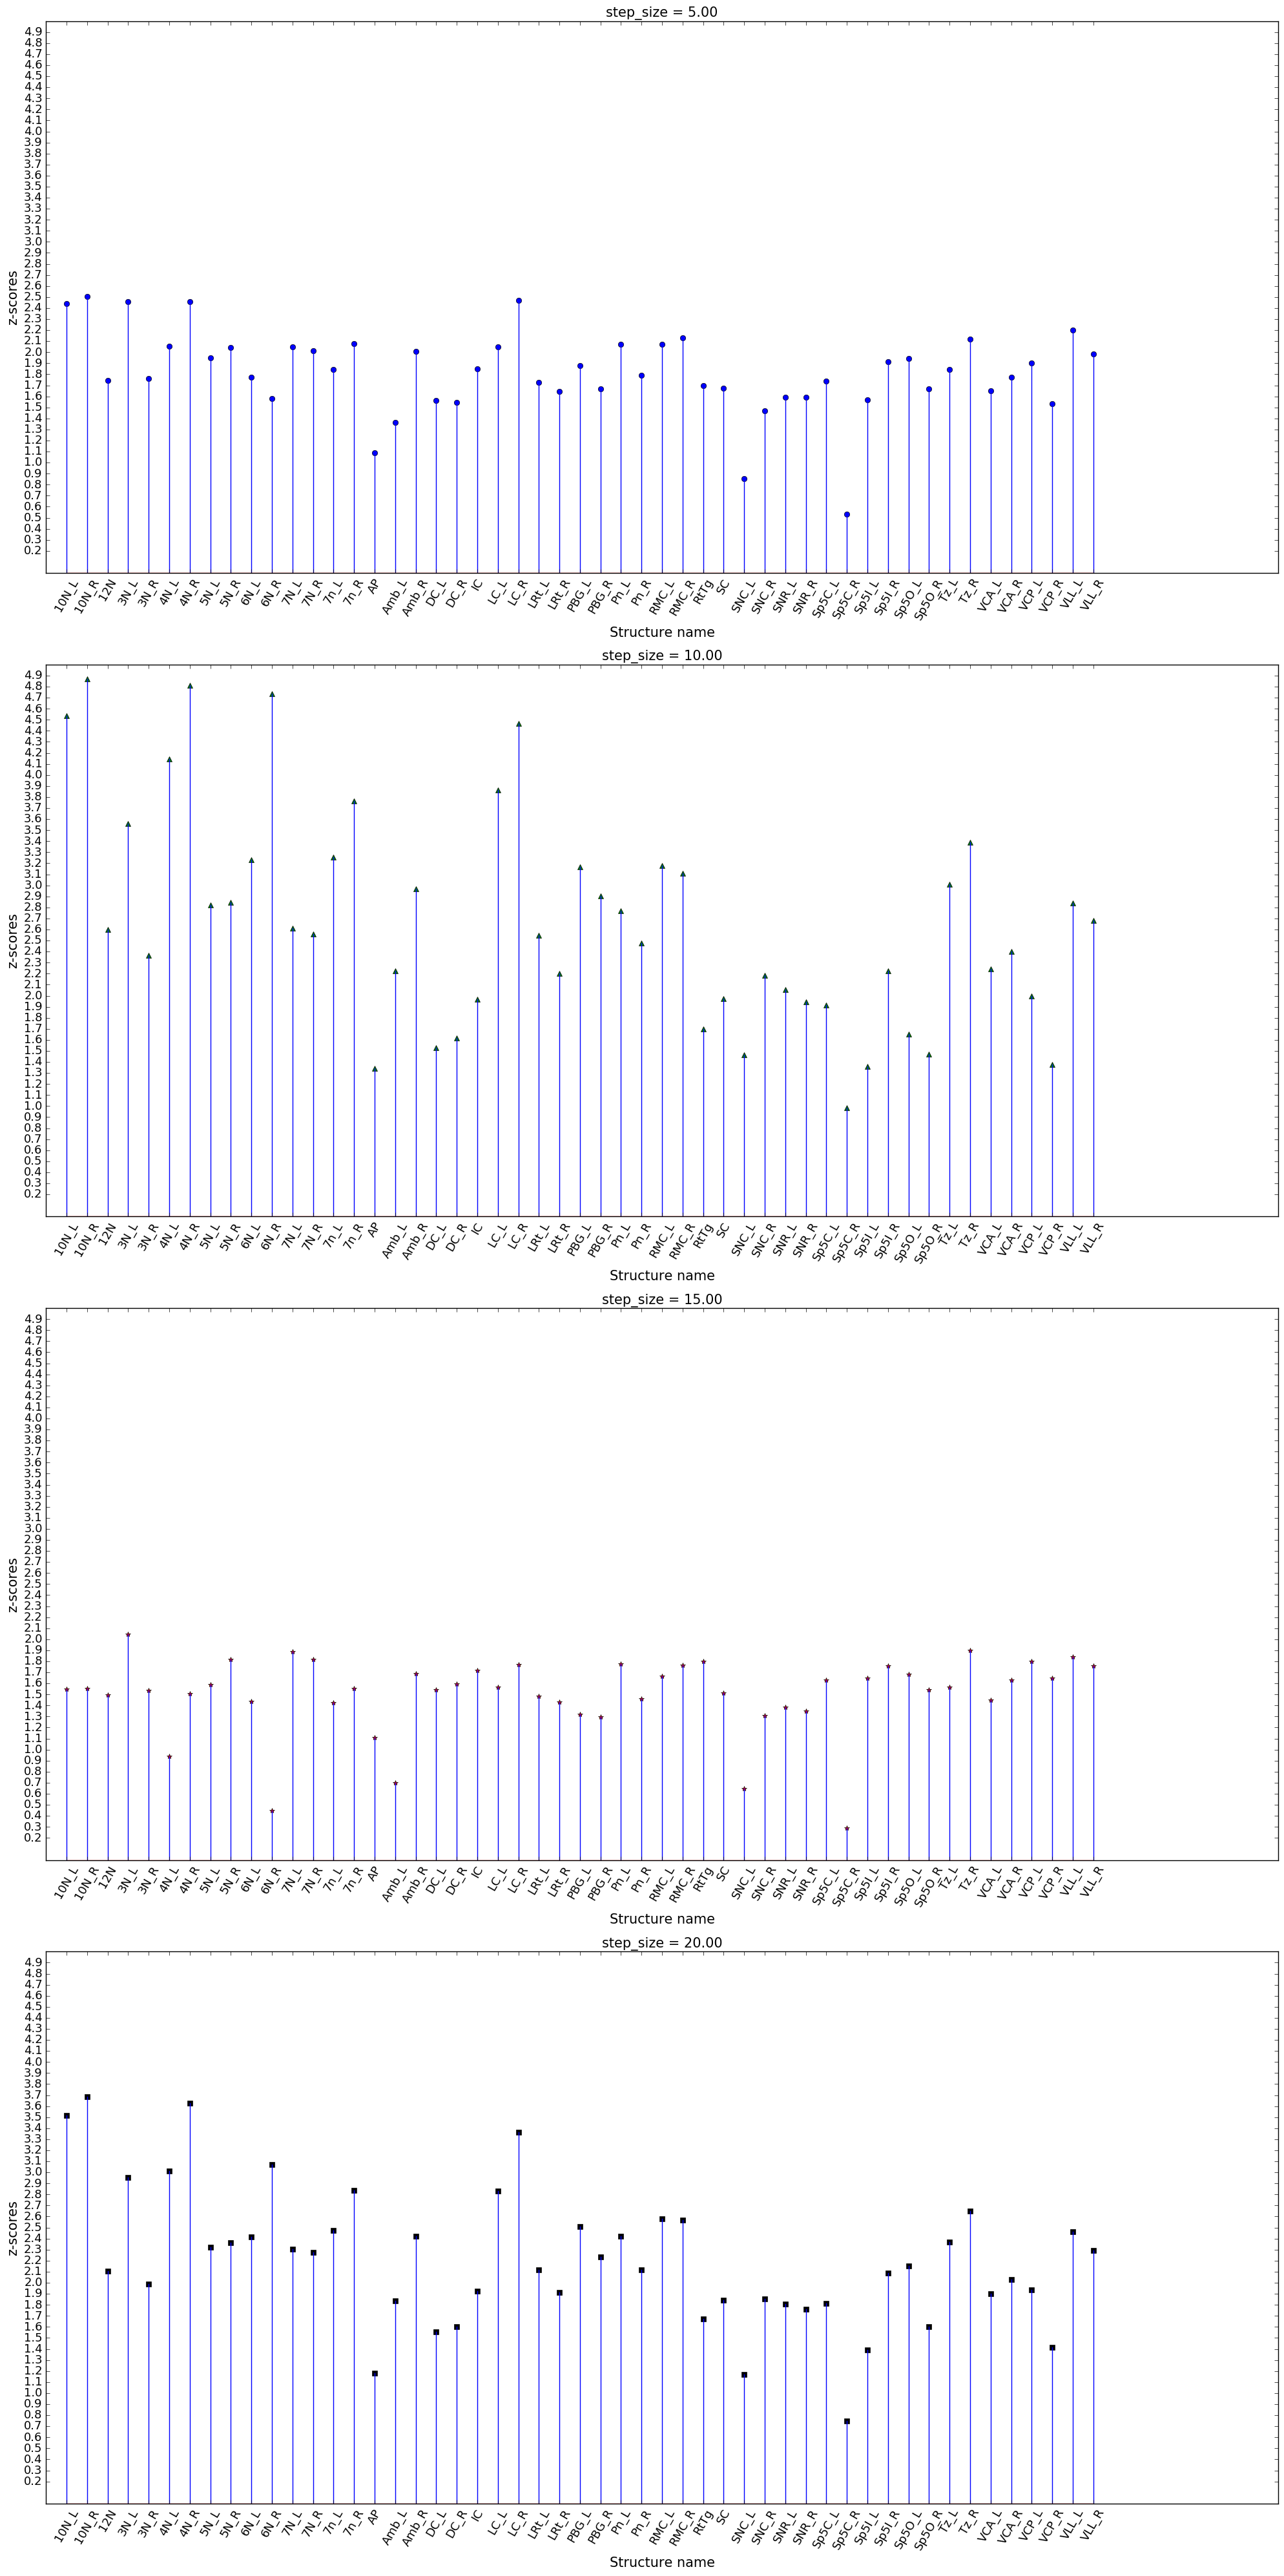

In [175]:
# fig = plt.figure(figsize=(20, 15));
fig, axes = plt.subplots(4, 1, figsize=(20, 40), sharex=False, sharey=True);

axes[0].stem(range(1, len(boxplot_labels)+1), D[:,0], markerfmt='bo', s=40);
axes[1].stem(range(1, len(boxplot_labels)+1), D[:,1], markerfmt='g^', s=40);
axes[2].stem(range(1, len(boxplot_labels)+1), D[:,2], markerfmt='r*', s=40);
axes[3].stem(range(1, len(boxplot_labels)+1), D[:,3], markerfmt='ks', s=40);

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, len(boxplot_labels)+1))
    ax.set_xticklabels(boxplot_labels, rotation='60', fontsize=13);
    ax.set_xlabel('Structure name', fontsize=15);
    ax.set_yticks(np.arange(0.2, 5, .1));
    ax.set_yticklabels(np.arange(0.2, 5, .1), fontsize=13);
    ax.set_ylabel('z-scores', fontsize=15);
    ax.set_title('step_size = %.2f' % pooling_radius_list[i], fontsize=15);

plt.tight_layout()

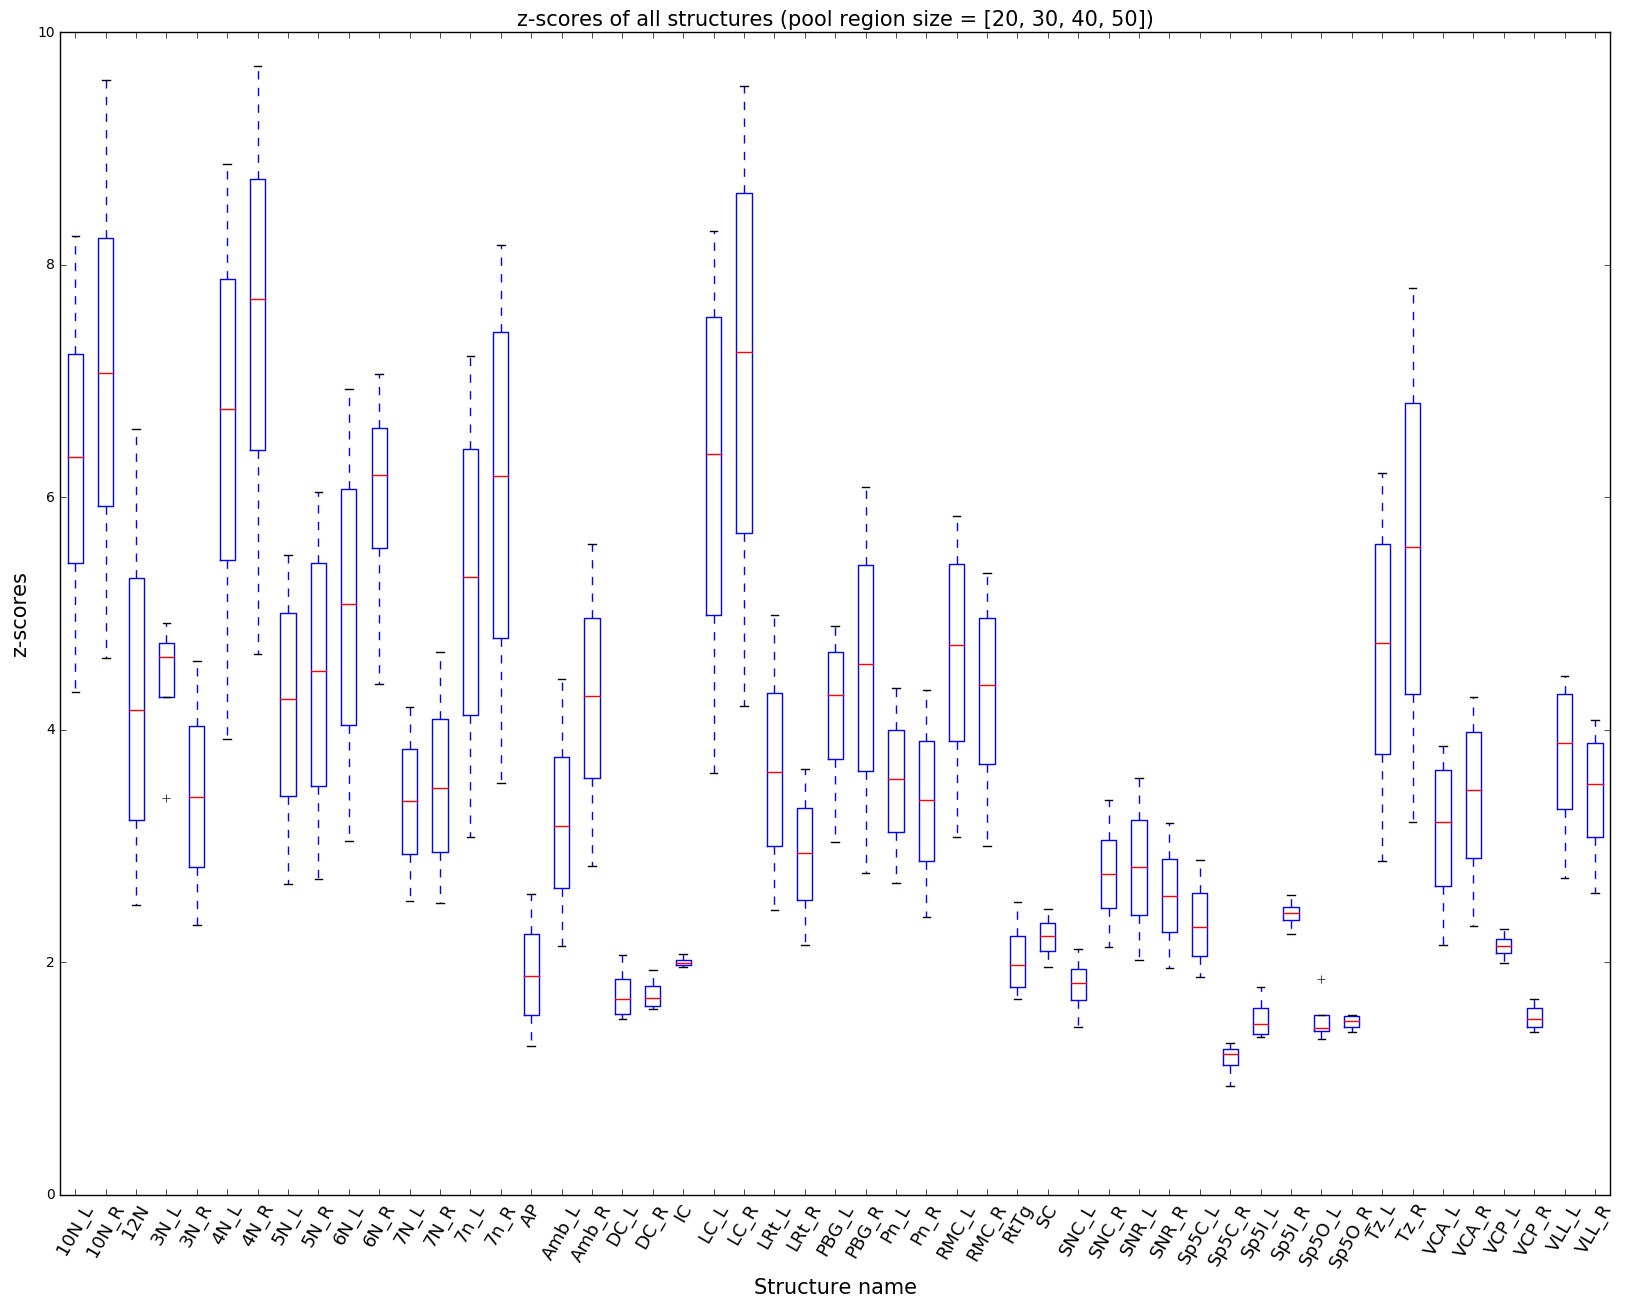

In [21]:
plt.figure(figsize=(20, 15));
plt.boxplot(D.T);
plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name', fontsize=15);
# plt.yticks(np.arange(0.2, 5, .1), fontsize=15);
plt.ylabel('z-scores', fontsize=15);
plt.title('z-scores of all structures (pool region size = %s)' % pooling_radius_list, fontsize=15);

In [89]:
volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}

# for lm, s in volume_moving_structure_sizes.iteritems():
#     print label_to_name_moving[lm], s, 'voxels'

In [127]:
dets_allStructures = {}

for name_s in structures_sided:

        
    fp = DataManager.get_hessian_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                        moving_volume_type='score', fixed_volume_type='score', 
                                        label=name_s,
                                        train_sample_scheme=train_sample_scheme, 
                                        global_transform_scheme=global_transform_scheme, 
                                        local_transform_scheme=local_transform_scheme)
    
    hessians = load_pickle(fp)
    
    dets = {step_size: np.abs(np.linalg.det(H / volume_moving_structure_sizes[name_to_label_moving[name_s]]))
            for step_size, H in hessians.iteritems()}
    
    dets_allStructures[name_s] = dets

In [134]:
H = [[z for r, z in d.items()][5:7] for n, d in sorted(dets_allStructures.items())]

In [130]:
boxplot_labels = sorted(dets_allStructures.keys())

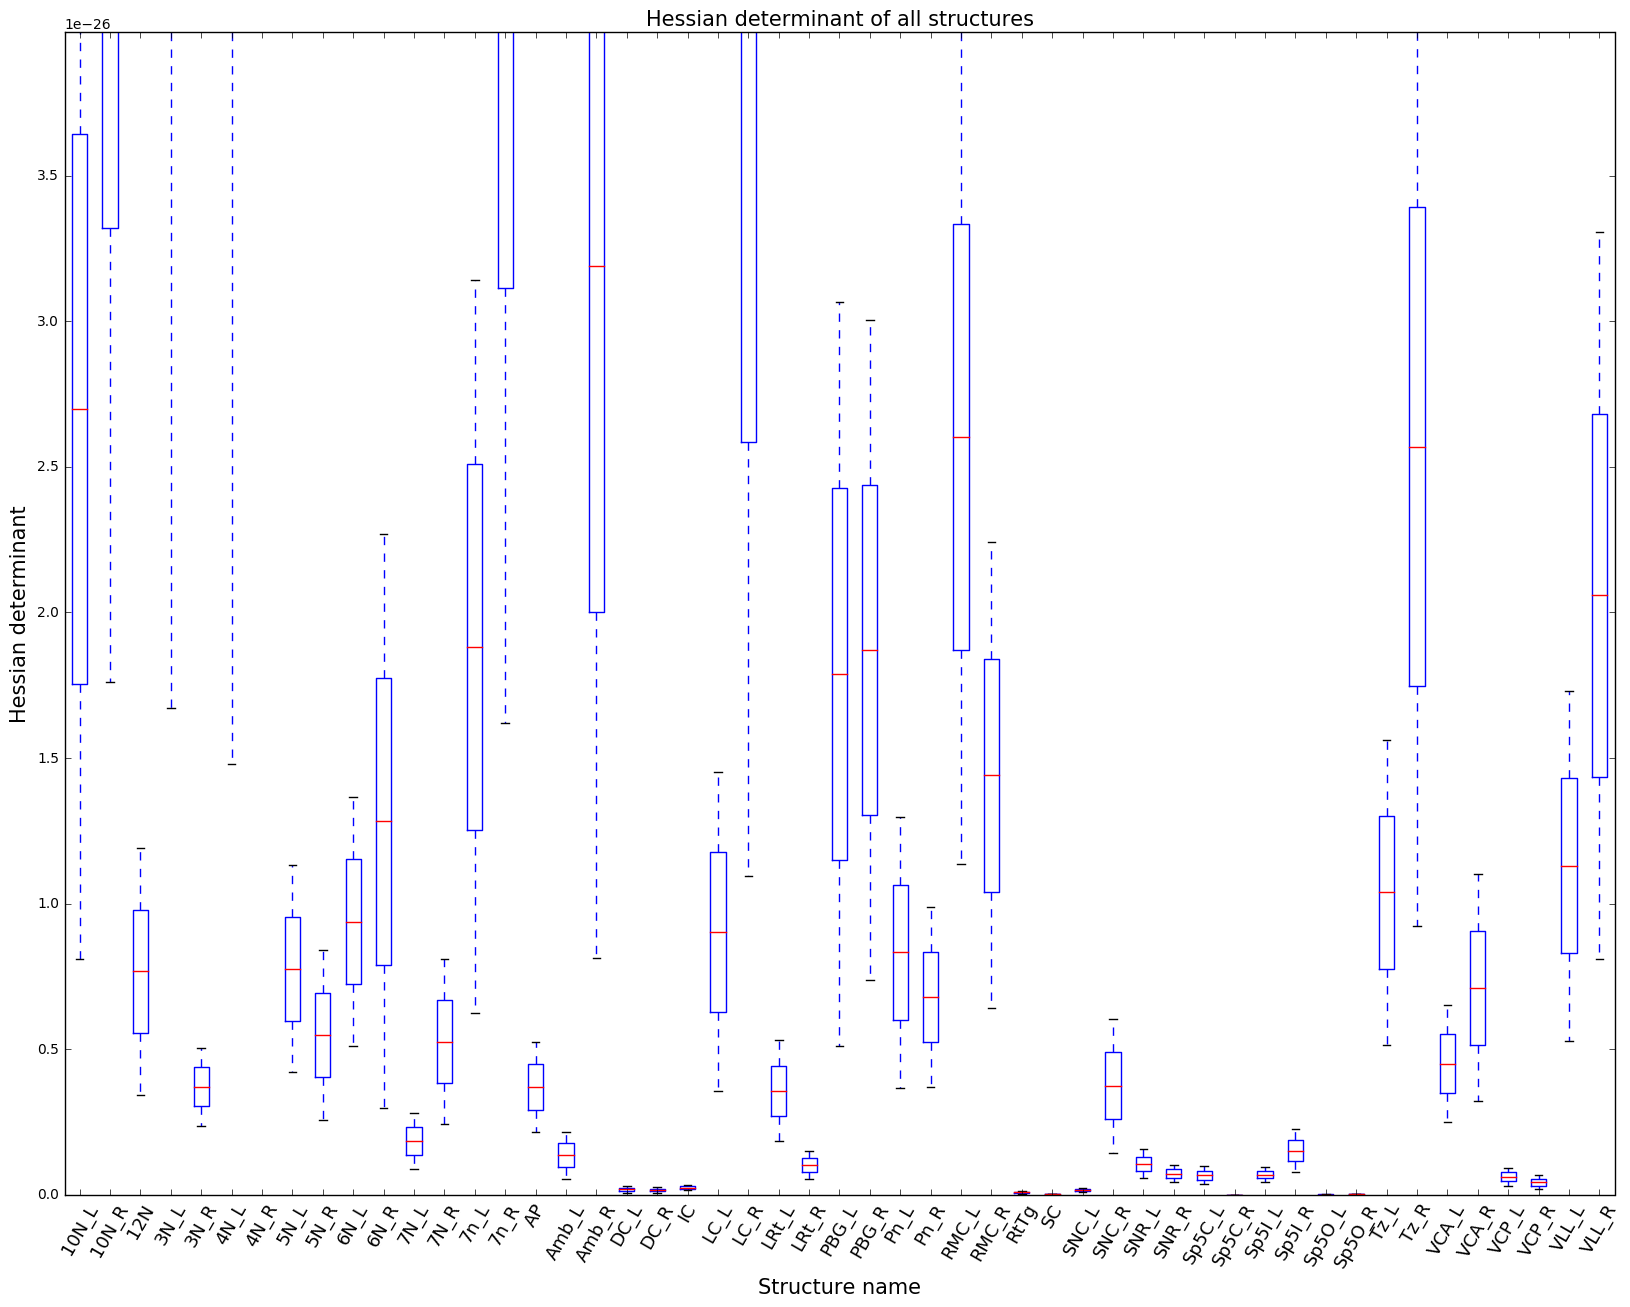

In [135]:
plt.figure(figsize=(20, 15));
plt.boxplot(H);
plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name', fontsize=15);
plt.ylim(0, np.percentile(H, 90));
plt.ylabel('Hessian determinant', fontsize=15);
plt.title('Hessian determinant of all structures', fontsize=15);

# NEW VERSION

# peak radius computed using largest eigenvalue


In [24]:
# peak radius computed using largest eigenvalue

peak_radius_allStructures = {}
zscores_allStructures = {}

for name_s in structures_sided:

        
    hessian_fp = DataManager.get_hessian_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                        moving_volume_type='score', fixed_volume_type='score', 
                                        label=name_s,
                                        train_sample_scheme=train_sample_scheme, 
                                        global_transform_scheme=global_transform_scheme, 
                                        local_transform_scheme=local_transform_scheme)
    
    hessians = load_pickle(hessian_fp)
    
    
    zscore_fp = DataManager.get_zscore_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                        moving_volume_type='score', fixed_volume_type='score', 
                                        label=name_s,
                                        train_sample_scheme=train_sample_scheme, 
                                        global_transform_scheme=global_transform_scheme, 
                                        local_transform_scheme=local_transform_scheme)
    
    zscores = load_pickle(zscore_fp)
    
    zscores_allStructures[name_s] = zscores
    
    ###################################################
        
    peak_radius = {}
        
    for pooling_radius, (zscore, fmax, mu, std) in zscores.iteritems():
        
        peak_radius[pooling_radius] = {}
        
        for step_size, (H, fmax) in hessians.iteritems():
            if pooling_radius > step_size * 2:  # compute only if pooling radius is at least twice the step size
                U, S, UT = np.linalg.svd(H)
                peak_radius[pooling_radius][step_size] = np.sqrt(2*(fmax-mu)/S[0])

    peak_radius_allStructures[name_s] = peak_radius
    

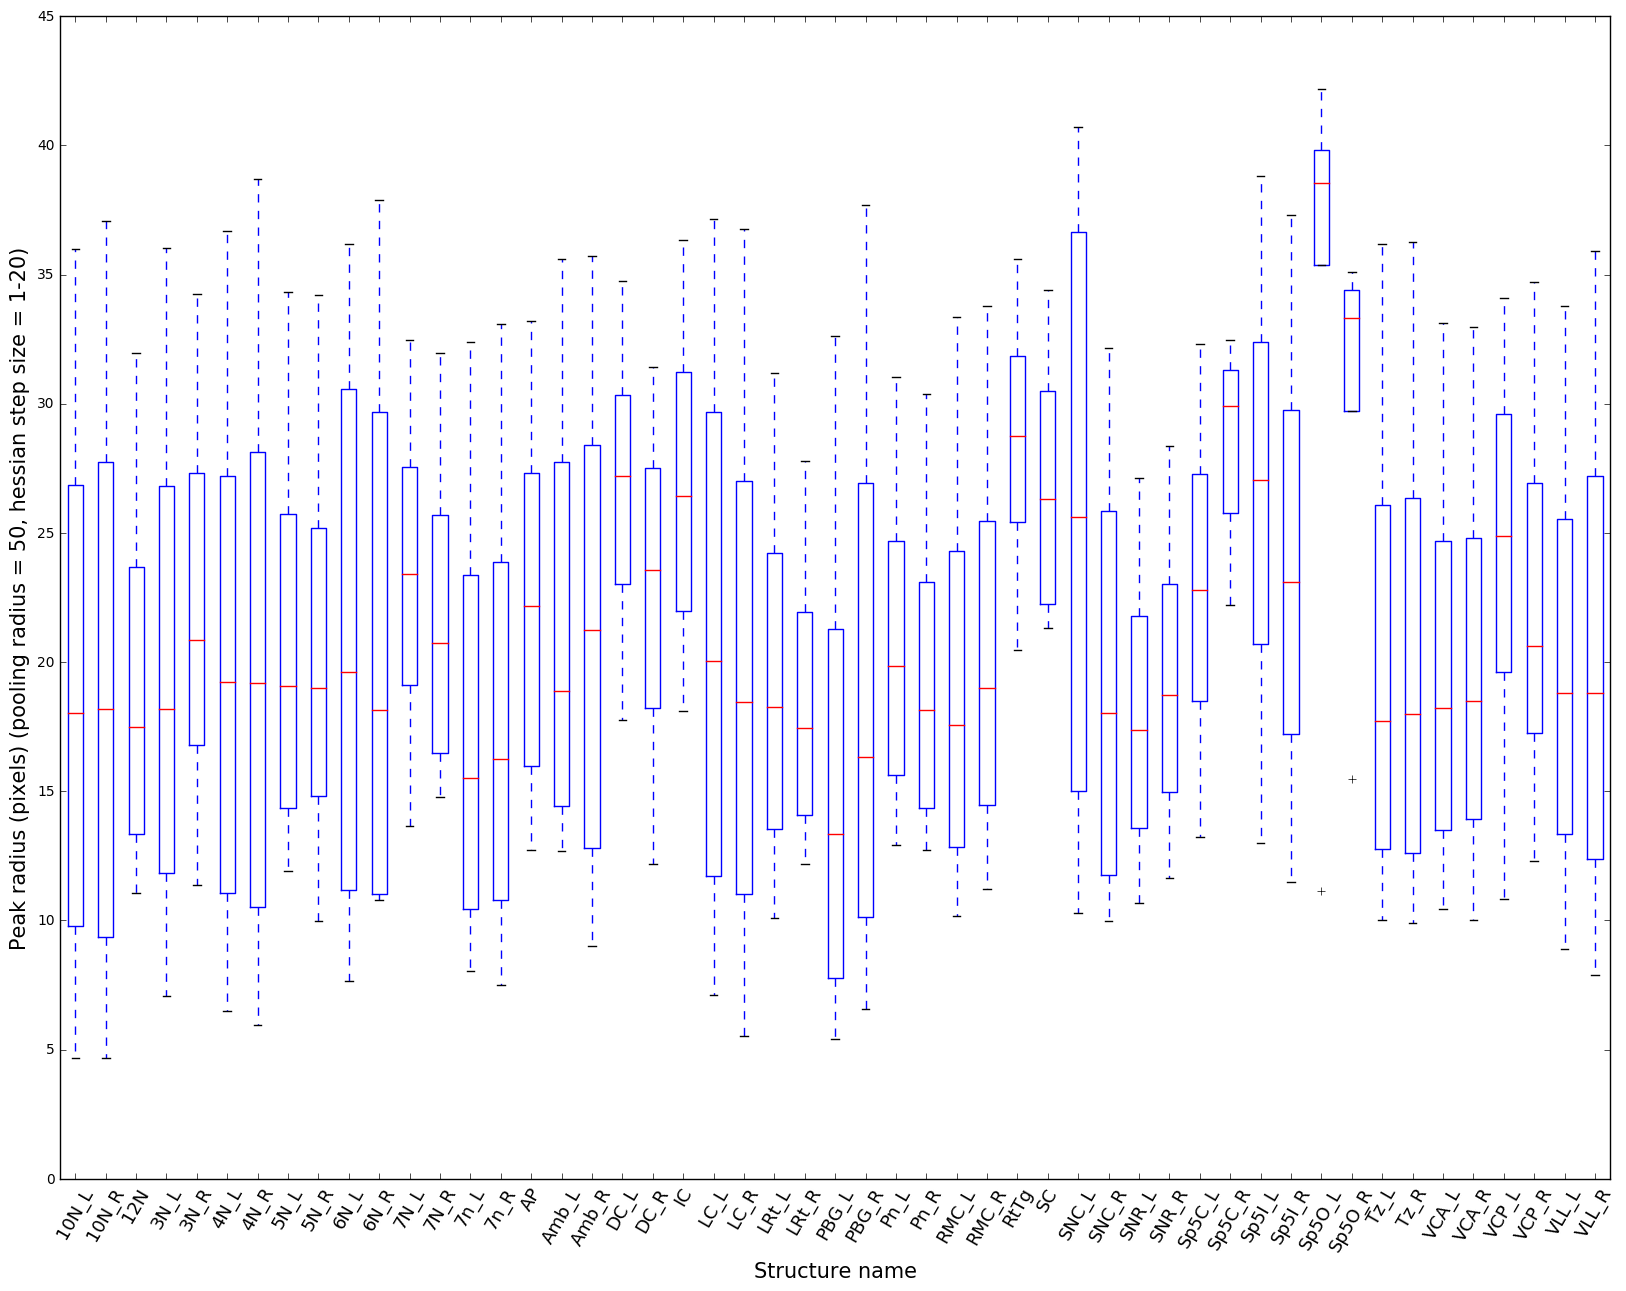

In [25]:
peak_radius_oneCombination = {n: x[50] for n, x in peak_radius_allStructures.iteritems()}
boxplot_labels = [n for n, x in sorted(peak_radius_oneCombination.items())]
D = [x.values() for n, x in sorted(peak_radius_oneCombination.items())]

plt.figure(figsize=(20, 15));
# plt.stem(range(1, len(boxplot_labels)+1), D);
plt.boxplot(D);
# plt.ylim([26, 42]);
plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name', fontsize=15);
plt.ylabel('Peak radius (pixels) (pooling radius = 50, hessian step size = 1-20)', fontsize=15);

# peak radius computed using smallest eigenvalue


In [30]:
# peak radius computed using smallest eigenvalue

peak_radius_allStructures = {}
zscores_allStructures = {}

for name_s in structures_sided:

        
    hessian_fp = DataManager.get_hessian_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                        moving_volume_type='score', fixed_volume_type='score', 
                                        label=name_s,
                                        train_sample_scheme=train_sample_scheme, 
                                        global_transform_scheme=global_transform_scheme, 
                                        local_transform_scheme=local_transform_scheme)
    
    hessians = load_pickle(hessian_fp)
    
    
    zscore_fp = DataManager.get_zscore_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                        moving_volume_type='score', fixed_volume_type='score', 
                                        label=name_s,
                                        train_sample_scheme=train_sample_scheme, 
                                        global_transform_scheme=global_transform_scheme, 
                                        local_transform_scheme=local_transform_scheme)
    
    zscores = load_pickle(zscore_fp)
    
    zscores_allStructures[name_s] = zscores
    
    ###################################################
        
    peak_radius = {}
        
    for pooling_radius, (zscore, fmax, mu, std) in zscores.iteritems():
        
        peak_radius[pooling_radius] = {}
        
        for step_size, (H, fmax) in hessians.iteritems():
            if pooling_radius > step_size * 2:  # compute only if pooling radius is at least twice the step size
                U, S, UT = np.linalg.svd(H)
                peak_radius[pooling_radius][step_size] = np.sqrt(2*(fmax-mu)/S[-1])

    peak_radius_allStructures[name_s] = peak_radius
    

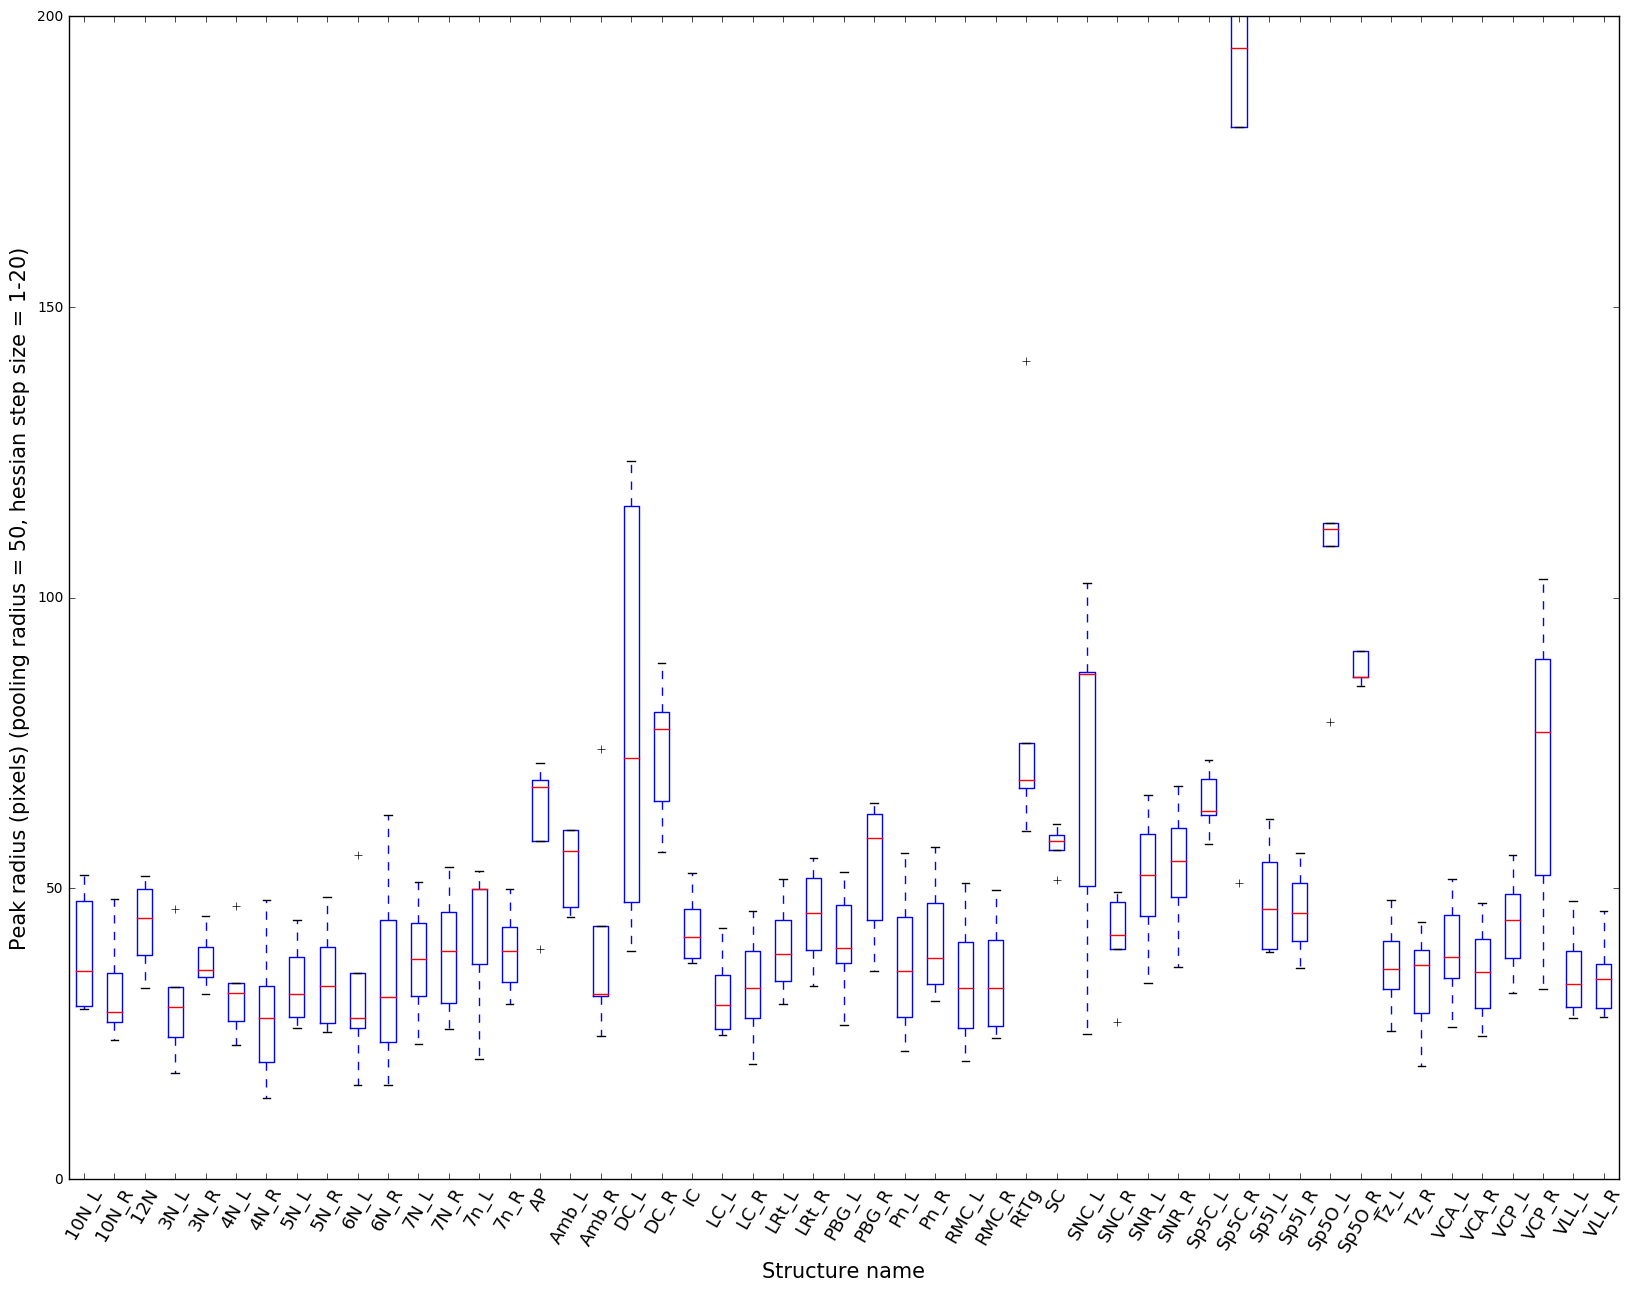

In [34]:
peak_radius_oneCombination = {n: x[50] for n, x in peak_radius_allStructures.iteritems()}
boxplot_labels = [n for n, x in sorted(peak_radius_oneCombination.items())]
D = [x.values() for n, x in sorted(peak_radius_oneCombination.items())]

plt.figure(figsize=(20, 15));
# plt.stem(range(1, len(boxplot_labels)+1), D);
plt.boxplot(D);
plt.ylim([0, 200]);
plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name', fontsize=15);
plt.ylabel('Peak radius (pixels) (pooling radius = 50, hessian step size = 1-20)', fontsize=15);

In [14]:
# dets_allStructures = {}
# zscores_allStructures = {}

# for name_s in structures_sided:
for name_s in ['7N_R']:
    
    if local_transform_scheme == 1 or local_transform_scheme == 2:
    
        aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: 
                                          volume_moving[name_to_label_moving[name_s]]}, \
                           labelIndexMap_m2f={name_to_label_moving[name_s]:
                                              name_to_label_fixed[convert_name_to_unsided(name_s)]})

    elif local_transform_scheme == 3 or local_transform_scheme == 4:
                
        aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: volume_moving[name_to_label_moving[name_s]],
                                         name_to_label_moving[name_s+'_surround']: volume_moving[name_to_label_moving[name_s+'_surround']]}, \
                        labelIndexMap_m2f={name_to_label_moving[name_s]: name_to_label_fixed[convert_name_to_unsided(name_s)],
                                          name_to_label_moving[name_s+'_surround']: name_to_label_fixed[convert_to_original_name(name_s+'_surround')]})

    aligner.set_label_weights(label_weights_m)
    aligner.set_regularization_weights(reg_weights)
        
    # aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
    aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', 
                         indices_m=[name_to_label_moving[name_s]])
    
    ########################################
    
    tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
        DataManager.load_local_alignment_parameters(stack_moving=stack_moving,
                                                    moving_volume_type='score',
                                                    stack_fixed=stack_fixed,
                                                    fixed_volume_type='score',
                                                    train_sample_scheme=train_sample_scheme,
                                                    global_transform_scheme=global_transform_scheme,
                                                    local_transform_scheme=local_transform_scheme,
                                                   label=name_s,
                                                   trial_idx=1)
        
    ###########################################
    
#     def perturb(tx, ty, tz):
#         return aligner.compute_score(tx_params + [0,0,0,tx,0,0,0,ty,0,0,0,tz])

# #     dets = []
#     Hs = []
#     step_sizes = np.linspace(1, 20, 11)

#     for step_size in step_sizes:
#         h = nd.Hessian(lambda (tx, ty, tz): perturb(tx, ty, tz), step=(step_size, step_size, step_size))
#         H = h((0,0,0))
#     #     s, v = np.linalg.eigh(H)
# #         d = np.abs(np.linalg.det(H))
# #         dets.append(d)
#         Hs.append(H)

#     plt.plot(dets);
#     plt.xlabel('step size (pixels)');
#     plt.xticks(range(len(step_sizes)), map(lambda x: '%.2f' % x, step_sizes));
#     plt.ylabel('determinant of Hessian matrix');
#     plt.title('Hessian for different step sizes');
#     plt.show();
    
#     dets_allStructures[name_s] = dets

    ############################################################
    
#     fp = DataManager.get_hessian_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
#                                         moving_volume_type='score', fixed_volume_type='score', 
#                                         label=name_s,
#                                         train_sample_scheme=train_sample_scheme, 
#                                         global_transform_scheme=global_transform_scheme, 
#                                         local_transform_scheme=local_transform_scheme)

#     create_if_not_exists(os.path.dirname(fp))
#     save_pickle(dict(zip(step_sizes, Hs)), fp)
    
    ############################################################

    fmax = aligner.compute_score(tx_params)

#     zscores = []
#     pooling_radius_list = np.linspace(5, 20, 4)

#     for pooling_radius in pooling_radius_list:
        
    pooling_radius = 5

#         print pooling_radius

    n_grid = 10
    neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, 
                                                               dxs=np.linspace(-pooling_radius, pooling_radius, n_grid),
                                                                dys=np.linspace(-pooling_radius, pooling_radius, n_grid),
                                                                dzs=np.linspace(-pooling_radius, pooling_radius, n_grid))
    z = (fmax - np.mean(neighbor_scores)) / np.std(neighbor_scores)

#     zscores.append(z)

#     plt.plot(pooling_radius_list, zscores);
#     plt.xlabel('pooling radius (pixels)');
#     # plt.xticks(range(len(pooling_radius_list)), map(lambda x: '%.2f' % x, pooling_radius_list));
#     plt.ylabel('z-score');
#     plt.title('Z-score for different pooling radius');
#     plt.show();
    
#     zscores_allStructures[name_s] = zscores
    

In [15]:
fmax

0.038657989352941513

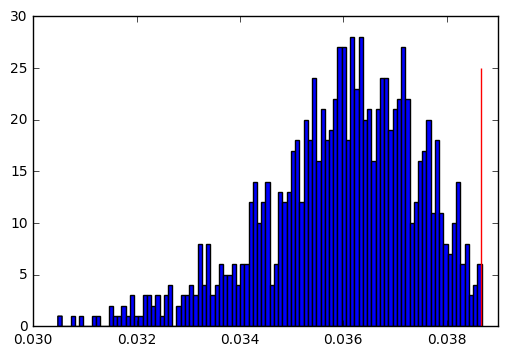

In [16]:
plt.hist(neighbor_scores, bins=100);
plt.vlines(fmax, 0, 25, colors='r');

In [147]:
# dets_allStructures = {}
# zscores_allStructures = {}

# for name_s in structures_sided:
for name_s in ['VLL_R']:
    
    if local_transform_scheme == 1 or local_transform_scheme == 2:
    
        aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: 
                                          volume_moving[name_to_label_moving[name_s]]}, \
                           labelIndexMap_m2f={name_to_label_moving[name_s]:
                                              name_to_label_fixed[convert_name_to_unsided(name_s)]})

    elif local_transform_scheme == 3 or local_transform_scheme == 4:
                
        aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: volume_moving[name_to_label_moving[name_s]],
                                         name_to_label_moving[name_s+'_surround']: volume_moving[name_to_label_moving[name_s+'_surround']]}, \
                        labelIndexMap_m2f={name_to_label_moving[name_s]: name_to_label_fixed[convert_name_to_unsided(name_s)],
                                          name_to_label_moving[name_s+'_surround']: name_to_label_fixed[convert_to_original_name(name_s+'_surround')]})

    aligner.set_label_weights(label_weights_m)
    aligner.set_regularization_weights(reg_weights)
        
    # aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
    aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', 
                         indices_m=[name_to_label_moving[name_s]])
    
    ########################################
    
    tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
        DataManager.load_local_alignment_parameters(stack_moving=stack_moving,
                                                    moving_volume_type='score',
                                                    stack_fixed=stack_fixed,
                                                    fixed_volume_type='score',
                                                    train_sample_scheme=train_sample_scheme,
                                                    global_transform_scheme=global_transform_scheme,
                                                    local_transform_scheme=local_transform_scheme,
                                                   label=name_s,
                                                   trial_idx=1)

    ############################################################

    fmax = aligner.compute_score(tx_params)

    pooling_radius = 5

#         print pooling_radius

    n_grid = 10
    neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, 
                                                               dxs=np.linspace(-pooling_radius, pooling_radius, n_grid),
                                                                dys=np.linspace(-pooling_radius, pooling_radius, n_grid),
                                                                dzs=np.linspace(-pooling_radius, pooling_radius, n_grid))
    z = (fmax - np.mean(neighbor_scores)) / np.std(neighbor_scores)


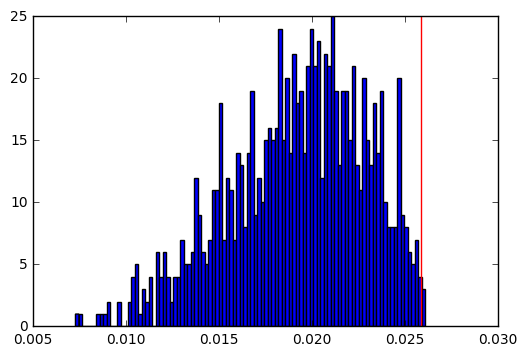

In [148]:
plt.hist(neighbor_scores, bins=100);
plt.vlines(fmax, 0, 25, colors='r');